# Zrimec et. al 2021

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
import os
import time
import matplotlib.pyplot as plt
import random
%pip install scikit-bio
from sklearn.metrics import precision_recall_curve, auc
from sklearn import preprocessing
from skbio.diversity import alpha_diversity
from skbio.stats.distance import DistanceMatrix
from numpy import zeros
from skbio.stats.ordination import pcoa

import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 75.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 72.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.3-cp311-cp311-linux_x86_64.whl size=7294508 sha256=9cd0a777f3ff071e719b126e1bb2727f18a534a47f8b4040f5e03fb7b2cfee47
  Stored in directory: /root/.cache/pip/wheels/c9/11/a2/86492071506a487bcba7015b710a9e89d66ca69845512fb86c
  Created wheel for biom-format: filename=biom_format-2.1.16-cp311-cp311-linux_x86_64.whl size=12182960 sha256=64b63b54d4c1f419c654d0a198e413aee62c958a25faa59a5ca0ad2ad58f2a7b
  Stored in directory: /root/.cache/pip/wheels/a5/6b/58/a879e8fbae2479a3d1a68719f3a062fe62701d6494f1b74f5e
Successf

In [ ]:
# variables
from scipy import stats
e_cut = 1e-16
col = 'group_id'
corr_f = stats.spearmanr
palett = sns.color_palette("Paired",8)
label_hits = 'Num. plastic degrading enzymes'
label_plast = 'Num. degradable plastic types'
label_hits_n = 'Num. plastic\ndegrading enzymes'
label_plast_n = 'Num. degradable\nplastic types'

# plastics as additional
additives = ['PA','phthalate','DBP','TP']
depth_order=['SRF','DCM','MES']
ocean_order=['MS','RS','IO','SO','SAO','NAO','SPO','NPO']
ocean_long={'MS':'Mediterranean Sea','RS':'Red Sea',
            'IO':'Ionian Sea','SO':'Southern Ocean',
            'SAO':'South Atlantic Ocean','NAO':'North Atlantic Ocean',
            'SPO':'South Pacific Ocean','NPO':'North Pacific Ocean'}
df_ocean = pd.DataFrame(ocean_long.keys(),columns=['short'])
df_ocean['long'] = ocean_long.values()
df_ocean.set_index('short').loc[ocean_order].values

col_env = ['8_Latitude of event (Latitude)',
           '9_Longitude of event (Longitude)',
           '18_Depth, reference [m] (Depth ref)',
             '19_Conductivity [mS/cm] (Cond)',
             '20_Salinity (Sal)',
             '21_Temperature, water, potential [°C] (Tpot)',
             '22_Density, sigma-theta (0) [kg/m',
             '23_Oxygen [µmol/kg] (OXYGEN)',
             '25_Nitrate [µmol/l] ([NO3]-)',
             '27_Phosphate [µmol/l] ([PO4]3-)',
             '28_Nitrate and Nitrite [µmol/l] ([NO3]- + [NO2]-)',
             '29_Silicate [µmol/l] (Si(OH)4)']

dic_env = dict(zip(col_env, ['Nitrate_nitrite' if '28' in x else
                             x.split('_')[1].split(' ')[0].replace(',','')
                             for x in col_env]))
# add units
dic_env2 = {'8_Latitude of event (Latitude)': 'Latitude [°]',
 '9_Longitude of event (Longitude)': 'Longitude [°]',
 '18_Depth, reference [m] (Depth ref)': 'Depth [m]',
 '19_Conductivity [mS/cm] (Cond)': 'Conductivity [mS/cm]',
 '20_Salinity (Sal)': 'Salinity',
 '21_Temperature, water, potential [°C] (Tpot)': 'Temperature [°C]',
 '22_Density, sigma-theta (0) [kg/m': 'Density [kg/m]',
 '23_Oxygen [µmol/kg] (OXYGEN)': 'Oxygen [µmol/kg]',
 '25_Nitrate [µmol/l] ([NO3]-)': 'Nitrate [µmol/l]',
 '27_Phosphate [µmol/l] ([PO4]3-)': 'Phosphate [µmol/l]',
 '28_Nitrate and Nitrite [µmol/l] ([NO3]- + [NO2]-)': 'Nitrate_nitrite [µmol/l]',
 '29_Silicate [µmol/l] (Si(OH)4)': 'Silicate [µmol/l]'}

In [ ]:
# functions

def get_prc(df_hits,plastic,plot=False):
    precision, recall, thresholds = precision_recall_curve(df_hits.label.values,
                       df_hits.score.values,
                       pos_label='tara')
    prc_auc = auc(recall,precision)

    if plot==True:
        plt.plot(recall, precision, color='darkorange',
                 lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.title(plastic)
        plt.show()

    return precision, recall, thresholds, prc_auc

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = corr_f(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.3f}, p = {p:.1e}', xy=(.1, .9), xycoords=ax.transAxes)

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

# merge on closest value
# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.iloc[idx].drop(columns = 'geometry').reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew, epsilon=False):
    """line fitting on log-log scale"""
    if epsilon==True:
        k, m = np.polyfit(np.log(x+1e-8), np.log(y+1e-8), 1)
    else:
        k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

#http://readiab.org/book/latest/3/1
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    if denominator == 0:
        denominator += 1e-8
    return numerator / denominator

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

def normalize(xx):
    mn = min(xx)
    mx = max(xx)
    return np.array([(x-mn)/(mx-mn) for x in xx])

# Load data

In [ ]:
# metadata
%pip install openpyxl
tara_metadata = (pd
                 .read_excel('Sunagawa_TableS1.xlsx',sheet_name='tableS1')
                 .rename(columns={'INSDC sample accession number(s)':'inscd_id',
                                  'INSDC run accession number(s)':'run',
                                  'Latitude [degrees North]':'latitude',
                                  'Longitude [degrees East]':'longitude'})
                )
tara_metadata['sample_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[:2]))
                             )
tara_metadata['depth_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['depth_id2'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['size_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[3:]))
                             )

# rename MIX as DCM
tara_metadata.loc[tara_metadata.depth_id=='MIX','depth_id'] = 'DCM'

print(tara_metadata.sample_id.unique().shape)
print(tara_metadata.shape)
tara_metadata.head()

# location grouping variables
marine_groups = ['Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]',
    'Marine provinces  (Longhurst 2007)',
    'Biogeographic biomes (Longhurst 2007)']

# define ocean, ocean province, biome
tara_metadata['ocean'] = tara_metadata[marine_groups[0]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['ocean_province'] = tara_metadata[marine_groups[1]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['biome'] = tara_metadata[marine_groups[2]]
tara_metadata['ocean_long'] = tara_metadata.ocean.map(ocean_long)
tara_metadata['group_id'] = tara_metadata.run

# prokaryote enriched fraction
print(tara_metadata[tara_metadata['size_id'].isin(['0.22-1.6','0.22-3'])].shape)
print(tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))&
              (tara_metadata.depth_id=='SRF')].shape)

# no pooling is required with this partitioning
(tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))&
              (tara_metadata.depth_id=='SRF')]
 .groupby('sample_id')['Size fraction upper threshold [micrometre]']
 .apply(lambda x: len(list(x)))
 .describe()
)
# replace id with the one we are using
to_replace = {'ERS492821|ERS492814':'ERS492814'}
tara_metadata = tara_metadata.replace({'inscd_id':to_replace})

tara_sample_map = pd.read_csv('tara-assembly-sample-mapping.txt'
                              ,sep='\t',names=['sample_id','inscd_id','samea_id'])

tara_sample_map['sample_id_short'] = (tara_sample_map
                                      .sample_id
                                      .apply(lambda x: x[:6])
                                     )
tara_sample_map

# load more env data
cols = (pd.read_csv('tara_env_column_names.tab',sep='*',
           usecols=[0],header=None)[0]
        .str.strip(' ') # drop trailing whitespace
        .reset_index()
       )
cols = (cols['index'].apply(str)+'_'+cols[0])

df_env = (pd
          .read_csv('output_pangea_sample_identifiers.tab',sep='\t',names=cols)
          .merge(tara_metadata[['inscd_id','PANGAEA sample identifier','group_id']],
                left_on='0_Sample ID (Sample ID)',
                 right_on='PANGAEA sample identifier',how='left')
          )
print(df_env.shape)
df_env.head()

(69,)
(243, 21)
(139, 26)
(63, 26)
(243, 66)


,0_Sample ID (Sample ID),1_Basis of event (Basis),2_Campaign of event (Campaign),3_Station label (Station),4_Event label (Event),5_Optional event label (Event 2),6_Method/Device of event (Method/Device),7_Date/Time of event (Date/Time),8_Latitude of event (Latitude),9_Longitude of event (Longitude),...,56_Sunshine duration [min] (SSD),"57_Geostrophic velocity, longitudinal [cm/s] (u)","58_Geostrophic velocity, latitudinal [cm/s] (v)",59_Okubo-Weiss parameter (OW),60_Maximum Lyapunov exponent [1/day] (MLE),"61_Sea surface temperature gradient, horizontal [°C/100 km] (SST grad h)",62_Residence time [days] (RT),inscd_id,PANGAEA sample identifier,group_id
0,TARA_X000000368,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1800Z_004_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-15T18:00,36.5533,-6.5669,...,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487936,TARA_X000000368,ERR598950|ERR599095
1,TARA_Y200000002,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1130Z_004_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-15T11:30,36.5533,-6.5669,...,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487899,TARA_Y200000002,ERR598955|ERR599003
2,TARA_A200000159,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1608Z_007_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-23T16:08,37.0541,1.9478,...,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477953,TARA_A200000159,ERR315856
3,TARA_A200000113,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1250Z_007_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-23T12:50,37.0510,1.9378,...,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477931,TARA_A200000113,ERR315857
4,TARA_X000001036,SV Tara,TARA_20090926Z,TARA_009,TARA_20090928T1659Z_009_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-28T16:59,39.0609,5.9422,...,714.0,-16.066,8.651,-0.774,0.083,24.398,24.74,ERS488147,TARA_X000001036,ERR594315|ERR594329


In [ ]:
# load

dfs = pd.read_csv('tara_assemblies_parsed.csv')
print(dfs.shape)

dfs['sample_id'] = (dfs.target_name
                     .apply(lambda x: x.split('|')[1][:6])
                     #.apply(lambda x: x.split('_')[0].split('.')[0])
                    )
dfs = (dfs
        .merge(tara_sample_map.drop(columns='sample_id'),
                        left_on='sample_id',
                        right_on='sample_id_short',
                        how='left')
      .drop(columns=['sample_id_short'])
      .merge(tara_metadata[['inscd_id','run','depth_id','size_id','ocean']],
             on='inscd_id',how='left')
     )

# prokaryote enriched fraction
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
       .inscd_id)

dfs = dfs[dfs.inscd_id.isin(tmp)].rename(columns={'e-value':'e_value'})
print(dfs.inscd_id.unique().shape)
print(dfs.shape)

# mark additives
dfs['additive'] = False
dfs.loc[dfs.plastic.isin(additives),'additive'] = True
dfs['group_id'] = dfs.run

# subset
dfs = dfs.query('e_value<=@e_cut')
print(dfs.shape)

(17681, 22)
(139,)
(12484, 29)
(11906, 31)


In [ ]:
# for text
(tara_metadata
 [(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
 ['Station identifier [TARA_station#]']
 .unique().shape
)

(67,)

# Analysis

In [ ]:
# all vs the rest significance test
test = stats.ranksums
what = 'Num. hits'
data = pd.concat(tmp).query('ylabel==@what')
data

ranksum = []
for var in data.ocean.unique():
    r,p = test(data.query('ocean==@var').value,
         data.query('ocean!=@var').value
        )
    n = data.query('ocean==@var').shape[0]
    ranksum.append([var,p,n])
pd.DataFrame(ranksum,columns=['ocean','p','n'])

ValueError: No objects to concatenate

In [ ]:
# per depth layer

tmp = []
tmp.append(dfs1.groupby(col).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs1.groupby(col).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs1.groupby(col).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# make separate plots
for coll in ["Num. plast.","Num. hits"]:
    plt.figure(figsize=(1,4))
    ax=sns.boxplot(data=pd.concat(tmp)
            .merge(tara_metadata[[col,'depth_id']],
                     on=col,how='left')
                .query('ylabel==@coll'),
               y='value',x='depth_id',
                   order=['SRF','DCM','MES']
               )
    if coll == 'Num. hits':
        plt.ylabel(label_hits)
        plt.yscale('log')
    else:
        plt.ylabel(label_plast)
    plt.xticks(rotation=45,ha='right')
    plt.xlabel('Depth layer')

    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')

    plt.show()

NameError: name 'dfs1' is not defined

# Correlation analysis

In [ ]:
df_rich = (dfs
   .groupby(col)
    .target_name.count()
    .rename(
      'num_hits')
    .reset_index()
)
df_rich['pl_richness'] = (dfs
   .groupby(col)
   .plastic.nunique()
   .values
)
df_rich['hmm_richness'] = (dfs
   .groupby(col)
   .hmm_model.nunique()
   .values
)
df_rich.head()

,group_id,num_hits,pl_richness,hmm_richness
0,ERR315856,47,7,20
1,ERR315857,68,7,21
2,ERR315858|ERR315861,62,7,18
3,ERR315859|ERR315860,74,6,18
4,ERR315862|ERR315863,112,7,22


### Environmental variables

In [ ]:
# merge
data = (df_rich
 .merge(df_env,
        on=col,how='left')
)

# correlatons
x = ['num_hits', 'pl_richness']
y = col_env
name_map = []
df_pcc = []
for colx in x:
    for coly in y:
        tmp1 = data[[colx,coly]].dropna()
        tmp2 = corr_f(tmp1[colx],tmp1[coly])
        df_pcc.append([colx,coly,tmp2[0],tmp2[1],tmp1.shape[0]])

df_pcc = (pd
          .DataFrame(df_pcc,columns=['x','y','r','p','n'])
          .query('p<1e-4')
          .sort_values(by='r',ascending=False)
          .replace({"y": dic_env})
         )
df_pcc.query('x.isin(["num_hits","pl_richness"])')

,x,y,r,p,n
14,pl_richness,Depth,0.551792,4.019477e-12,135
20,pl_richness,Nitrate,0.454453,6.910839e-07,109
18,pl_richness,Density,0.394944,2.781039e-06,132
2,num_hits,Depth,0.384048,4.258685e-06,135
6,num_hits,Density,0.381601,6.343546e-06,132
5,num_hits,Temperature,-0.336313,6.661182e-05,135
1,num_hits,Longitude,-0.357203,1.584400e-05,139
13,pl_richness,Longitude,-0.392967,1.708920e-06,139
15,pl_richness,Conductivity,-0.417588,6.305319e-07,132
17,pl_richness,Temperature,-0.450976,4.040710e-08,135


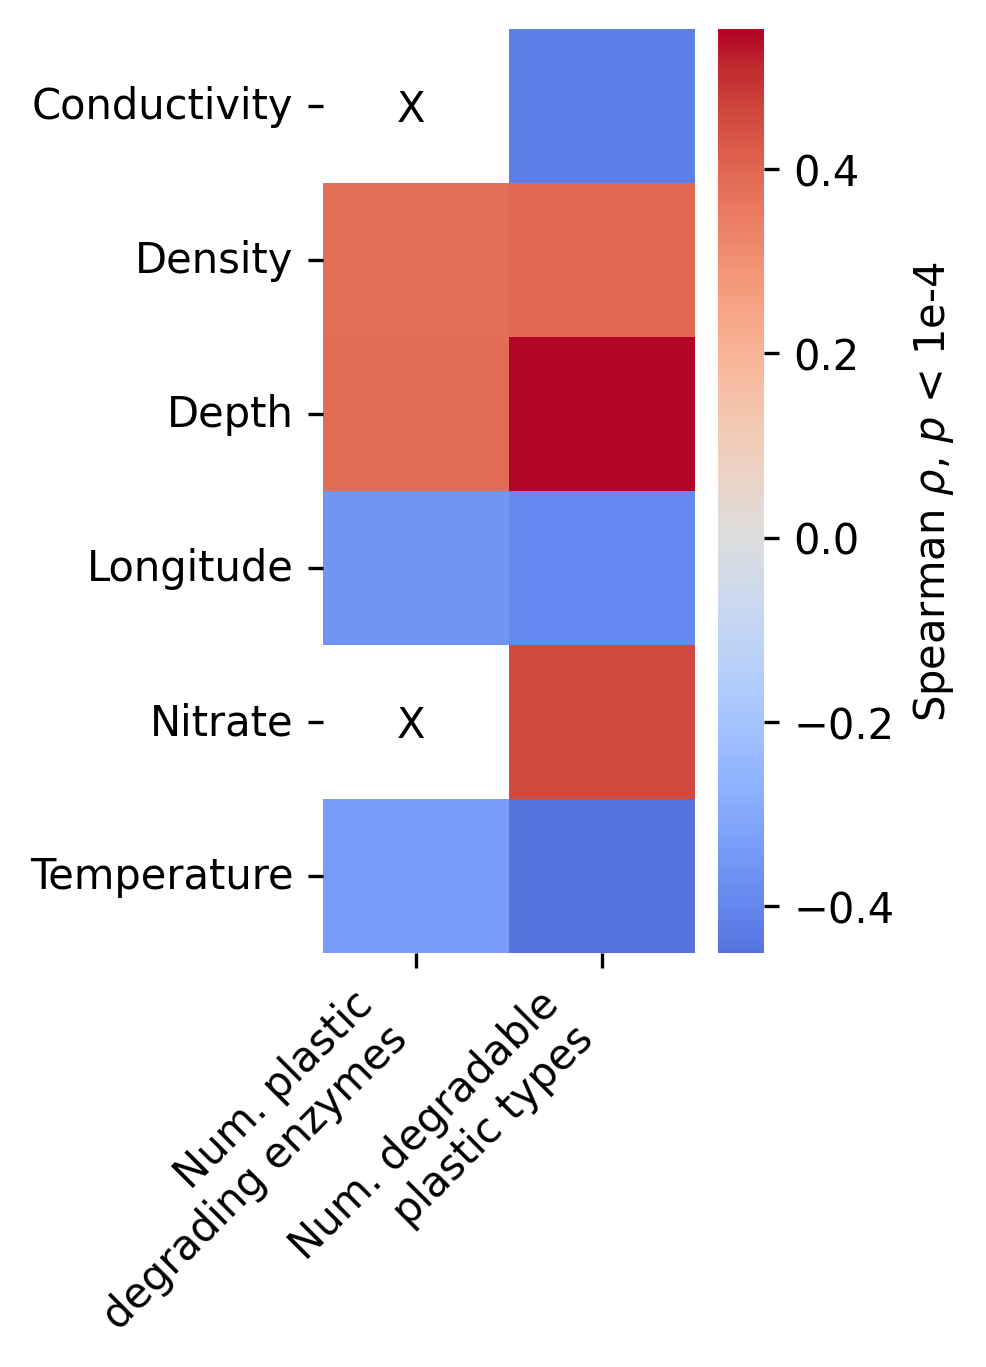

In [ ]:
# plot this heatmap
dic_x = {'num_hits':label_hits_n,
         'pl_richness':label_plast_n
        }

# get data to df
data = (df_pcc
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .pivot(index='x',columns='y',values='r')
        .transpose()
       )
data

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,4))
sns.heatmap(data[[label_hits_n,label_plast_n]], # ordering
            cmap='coolwarm',
            center=0,
            cbar_kws={'label': "Spearman "+r'$\rho$, $p$ < 1e-4',
                    },
           )
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0,ha='right')
#plt.title('$p$ < 1e-4')

# plot xs for variables that are not below p-val cutoff
plt.annotate('X',xy=(0.4,0.6))
plt.annotate('X',xy=(0.4,4.6))

plt.show()


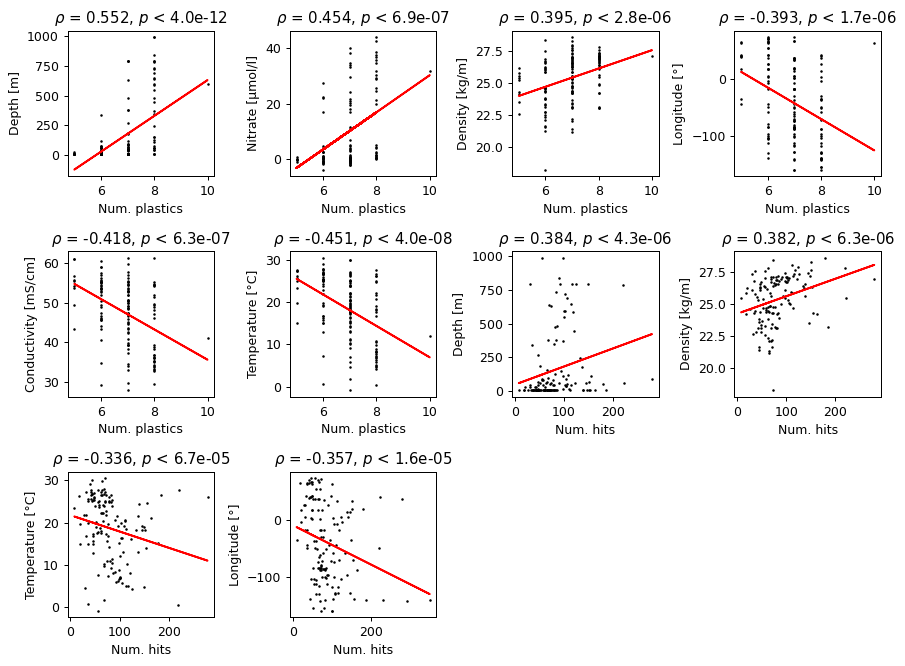

In [ ]:
# Plot all correlations subplot
dic_x = {'num_hits': 'Num. hits',
         'pl_richness': 'Num. plastics'
        }

mpl.rcParams['figure.dpi'] = 90
dic_env_inv = {v: k for k, v in dic_env.items()}
data = (df_rich
 .merge(df_env,
        on=col,how='left')
)
tmp = (df_pcc
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .sort_values(by='x',ascending=False)
)

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(10,7.5))
k=1
for idx,row in tmp.iterrows():

    plt.subplot(3,4,k)
    var1 = df_pcc.loc[idx].x
    var2 = dic_env_inv[df_pcc.loc[idx].y]
    x = data[[var1,var2]].dropna()[var1]
    y = data[[var1,var2]].dropna()[var2]

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, slope*x+intercept, 'r', label='fitted line')
    plt.xlabel(row.x)
    plt.ylabel(dic_env2[var2])
    plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
            ', $p$ < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
    k+=1

plt.tight_layout()
plt.show()

### Pollution data

In [ ]:
# load pollution data
import pandas as pd

df_pol = []

# Total Pieces/L, global
df_pol.append(pd
              .read_excel('WW Marine Datashare.xlsx',sheet_name='Q1')
              .rename(columns={'Sample Longitude':'longitude',
                               'Sample Latitude':'latitude',
                               'Total Pieces/L':'conc'
                              })
             )
df_pol[-1]['dataset'] = 'adventure'

# g/km2, global
df_pol.append(pd
              .read_excel('PlasticMarinePollutionGlobalDataset_Eriksen2014.xlsx')
              .drop(0)
              .rename(columns={'Longitude':'longitude',
                               'Latitude':'latitude'})
             )
# merge concentrations across all plastic sizes
#df_pol[-1]['dataset'] = 'eriksen2014'
#print(df_pol)

df_pol[-1]['conc'] = (df_pol[-1]['WD1'].fillna(0)+
                      df_pol[-1]['WD2'].fillna(0)+
                      df_pol[-1]['WD3'].fillna(0)+
                      df_pol[-1]['WD4'].fillna(0))
df_pol[-1]['dataset'] = 'eriksen2014'

# pieces/km2, this is only pacific
df_pol.append(pd.read_csv('Pacific_Law_plastics.txt',
                      delim_whitespace=True,skiprows=1,
                     names=['month','day','year','longitude','latitude','conc']))
df_pol[-1]['dataset'] = 'law2014'

# mg/m³, only north pacific
df_pol.append(pd
              .read_csv('MicroplasticNumericalandMassConcentration_Goldstein2012.csv')
                .rename(columns={'Longitude (º)':'longitude',
                                 'Latitude (º)':'latitude',
                                 'Microplastic Mass (mg/m³)':'conc'})
             )
df_pol[-1]['dataset'] = 'goldstein2012'

# standardize
for d in df_pol:
    a,_ = stats.boxcox([x+1 for x in normalize(d.conc.values)])
    d['conc_box_zscore'] = preprocessing.scale(a)

KeyError: 'WD1'

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# fit tara location data to geo-data stucture
geometry = [Point(xy) for xy in zip(tara_metadata['longitude'],
                                     tara_metadata['latitude'])]

geo_df = (gpd
          .GeoDataFrame(tara_metadata[col],
                          geometry=geometry)
         )

In [ ]:
# make geo dfs
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
geo_df_pol = []
for x in df_pol:
    geo_df_pol.append(gpd.GeoDataFrame(x[['conc_box_zscore','dataset']],
                          geometry=[Point(xy) for xy in zip(x['longitude'],
                                        x['latitude'] )])
                     )
print([len(x) for x in geo_df_pol])

geo_df_near = []
for x in geo_df_pol:
  geo_df_near.append(ckdnearest(geo_df, x))



geo_df_near = pd.concat(geo_df_near)
geo_df_near['dist'] = geo_df_near.dist*100 # dist in km

print(geo_df_near.shape)

# prokaryote enriched fraction + surface fraction only
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))
              &(tara_metadata.depth_id=='SRF')][col])

# remove nan datasets
geo_df_near = (geo_df_near
               .dropna(subset=['dataset'])
               .query('group_id.isin(@tmp)')
              )

print(geo_df_near.shape)
geo_df_near.head()

geo_df_near.to_csv("pollutionData.txt", sep='\t')



KeyError: "['conc_box_zscore'] not in index"

# My Analysis

In [ ]:
data_dict = {}

with open('pollutionData.txt', 'r') as input_file:
    next(input_file)
    for line in input_file:
        values = line.strip().split('\t')
        key = (values[0], values[1])
        distance = float(values[5])

        if key in data_dict:
            existing_value = data_dict[key]
            if distance < existing_value[1] and distance < 400:
                data_dict[key] = (values[3], distance)
        elif distance < 400:
            data_dict[key] = (values[3], distance)

with open('smallest_dist.txt', 'w') as output_file:
    for key, value in data_dict.items():
        output_file.write(f"{key[0]}\t{key[1]}\t{value[0]}\t{value[1]}\n")


In [ ]:
# Map the pollution in smallest_dist.txt to the sample location in Sunagawa file using the enzyme id in both files
import pandas as pd

sunagawa_data = pd.read_excel('Sunagawa_TableS1.xlsx')

new_data = pd.read_csv('smallest_dist.txt', sep='\t', header=None)

# map 3rd column to 1st column
mapping_dict = dict(zip(sunagawa_data.iloc[1:, 2], sunagawa_data.iloc[1:, 0]))

# replace 2nd column with corresponding 1st column
new_data[1] = new_data[1].map(mapping_dict)

new_data.to_csv('mapped.txt', sep='\t', header=False, index=False)

In [ ]:
import pandas as pd

file3_path = 'TARA243.KO.profile.release'
df3 = pd.read_csv(file3_path, delimiter='\t')

file2_path = 'mapped.txt'
df2 = pd.read_csv(file2_path, delimiter='\t', header=None, names=['ID', 'Sample', 'Value1', 'Value2'])

df_ko_filtered = df3.iloc[:, 0:1]

sample_names_to_keep = df2['Sample'].unique()
columns_to_keep_ko = [col for col in df3.columns if any(sample_name in col for sample_name in sample_names_to_keep)]
df_ko_filtered = pd.concat([df_ko_filtered, df3[columns_to_keep_ko]], axis=1)

output_ko_file_path = 'TARA243_KO_filtered.KO.profile.release'
df_ko_filtered.to_csv(output_ko_file_path, sep='\t', index=False)

# Calculating Pearson's Correlation

In [ ]:

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Load the enzyme abundance data (release file)
release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

# Load the mapped data with corresponding pollution values
mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values (sample IDs) and y values (pollution values)
second_values = mapped_data[1].values
y_values = mapped_data[2].values

# Dictionary to store correlation coefficients
correlation_coefficients = {}
x_values_for_all_enzymes = []  # List to store x_values for all enzymes

# Iterate over each row of the enzyme abundance data
for row_index in range(len(release_df)):
    # Extract the x_values corresponding to each sample (second_value)
    x_values = [release_df.iloc[row_index][str(second_value)] for second_value in second_values]

    # Calculate the correlation coefficient for this enzyme
    correlation_coefficient = calculate_correlation(x_values, y_values)
    correlation_coefficients[row_index] = correlation_coefficient

    # Store the x_values along with the enzyme name for future output
    enzyme_name = release_df.iloc[row_index, 0]  # Assuming the first column contains enzyme names
    x_values_for_all_enzymes.append([enzyme_name] + x_values)

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Create a list of the first column values (enzyme names) from the release file
first_column_values = release_df.iloc[:, 0].values

# Save the sorted correlation coefficients to a text file
with open("all_pearson_correlations.txt", "w") as file:
    for row_index, correlation_coefficient in sorted_coefficients:
        first_value = first_column_values[row_index]  # Get the corresponding enzyme name
        file.write(f"Row {row_index}: Enzyme = {first_value}, Correlation = {correlation_coefficient}\n")

# Save the x_values for all enzymes to a CSV file
# Now, the column names are based on the corresponding y_values used in the calculation
column_names = ['Enzyme'] + [f'Pollution_{y_val}' for y_val in y_values]  # Using y_values as sample identifiers
x_values_df = pd.DataFrame(x_values_for_all_enzymes, columns=column_names)
x_values_df.to_csv('pearson_x_y_values.csv', index=False)


##### T-Distribution

In [ ]:
import numpy as np
import scipy.stats as stats

def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

degrees_of_freedom = 39

# Calculate and add the t-value distribution to the output file
with open("all_pearson_correlations.txt", "w") as file:
    for row_index, correlation_coefficient in sorted_coefficients:
        first_value = first_column_values[row_index]  # Get the corresponding first value

        # Calculate the new value and t-value probability distribution
        x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        file.write(f"Row {row_index}: First Value = {first_value}, Correlation Coefficient = {correlation_coefficient}, x = {x}, Probability = {probability}\n")


In [ ]:
significant_rows = []

# Initialize the total probability
total_probability = 0

# Iterate through the sorted coefficients
for row_index, correlation_coefficient in sorted_coefficients:
    first_value = first_column_values[row_index]  # Get the corresponding first value

    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    # Check if adding the current probability exceeds 1
    if total_probability + probability <= 1:
        significant_rows.append((row_index, first_value, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values and y values from mapped_data
second_values = mapped_data[1].values
y_values = mapped_data[2].values

if significant_rows:
    significant_rows = significant_rows[:-1]

# Write the modified content back to the file, excluding the last row
with open("sig_pearson_enzymes.txt", "w") as file:
    for row_index, first_value, correlation_coefficient, x, probability in significant_rows:
        file.write(f"Enzyme = {first_value}, Correlation = {correlation_coefficient}\n")
        #, x = {y_values}


#### Correlation calculation & t-dist

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.stats import pearsonr

# Function to calculate correlation
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

# Degrees of freedom for the t-distribution
degrees_of_freedom = 39

# Load the enzyme abundance data (release file)
release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

# Load the mapped data with corresponding pollution values
mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values (sample IDs) and y values (pollution values)
second_values = mapped_data[1].values
y_values = mapped_data[2].values

# Dictionary to store correlation coefficients and x values for each enzyme
correlation_coefficients = {}
x_values_for_all_enzymes = []  # List to store x_values for all enzymes

# Iterate over each row of the enzyme abundance data
for row_index in range(len(release_df)):
    # Extract the x_values corresponding to each sample (second_value)
    x_values = [release_df.iloc[row_index][str(second_value)] for second_value in second_values]

    # Resize y_values to match the length of x_values
    desired_length = len(x_values)
    y_values_resized = np.resize(y_values, desired_length)

    # Calculate the correlation coefficient for this enzyme
    correlation_coefficient = calculate_correlation(x_values, y_values_resized)
    correlation_coefficients[row_index] = correlation_coefficient

    # Store the x_values along with the enzyme name for future output
    enzyme_name = release_df.iloc[row_index, 0]  # Assuming the first column contains enzyme names
    x_values_for_all_enzymes.append([enzyme_name] + x_values)

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Create a list of the first column values (enzyme names) from the release file
first_column_values = release_df.iloc[:, 0].values

# Now calculate the t-value and p-value for the sorted coefficients and prepare for output
significant_rows = []
total_probability = 0

for row_index, correlation_coefficient in sorted_coefficients:
    first_value = first_column_values[row_index]  # Get the corresponding enzyme name
    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    # Check if adding the current probability exceeds 1
    if total_probability + probability <= 1:
        significant_rows.append((row_index, first_value, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

# Write the results to sig_pearson_enzymes.txt
with open("sig_pearson_enzymes.txt", "w") as file:
    for row_index, first_value, correlation_coefficient, x, probability in significant_rows:
        file.write(f"Enzyme = {first_value}, Correlation = {correlation_coefficient}, t-dist = {x}, p-value = {probability}\n")


In [ ]:
import csv

# Processing the first file and outputting to both .csv and .tab files
with open('all_pearson_correlations.txt', 'r') as input_file:
    # Output to .tab file
    with open('all_pearson_correlations.tab', 'w', newline='') as tab_output_file:
        tab_writer = csv.writer(tab_output_file, delimiter='\t')  # Use tab as delimiter
        tab_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

        # Output to .csv file
        with open('all_pearson_correlations.csv', 'w', newline='') as csv_output_file:
            csv_writer = csv.writer(csv_output_file)  # Use default comma delimiter
            csv_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

            for line in input_file:
                line = line.strip()
                parts = line.split(',')

                if len(parts) == 2:
                    enzyme = parts[0].split('=')[1].strip()  # Get the enzyme
                    correlation = float(parts[1].split('=')[1].strip())  # Get the correlation and convert to float
                    tab_writer.writerow([enzyme, correlation])  # Write to tab file
                    csv_writer.writerow([enzyme, correlation])  # Write to csv file

# Processing the second file and outputting to both .csv and .tab files
with open('sig_pearson_enzymes.txt', 'r') as infile:
    lines = infile.readlines()

    # Output to .tab file
    with open('sig_pearson_enzymes.tab', 'w', newline='') as tab_output_file:
        tab_writer = csv.writer(tab_output_file, delimiter='\t')  # Use tab as delimiter
        tab_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

        # Output to .csv file
        with open('sig_pearson_enzymes.csv', 'w', newline='') as csv_output_file:
            csv_writer = csv.writer(csv_output_file)  # Use default comma delimiter
            csv_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

            # Write the data rows
            for line in lines:
                parts = line.strip().split(', ')  # Split each line into parts
                enzyme = parts[0].split(' = ')[1]  # Get the enzyme ID
                correlation = parts[1].split(' = ')[1]  # Get the correlation value
                tab_writer.writerow([enzyme, correlation])  # Write to tab file
                csv_writer.writerow([enzyme, correlation])  # Write to csv file


## Spearman Correlation Calculation

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr  # Import spearmanr instead of pearsonr

def calculate_correlation(x_values, y_values):
    # Calculate Spearman correlation coefficient
    correlation_coefficient, _ = spearmanr(x_values, y_values)
    return correlation_coefficient

# Load the enzyme abundance data (release file)
release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

# Load the mapped data with corresponding pollution values
mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values (sample IDs) and y values (pollution values)
second_values = mapped_data[1].values
y_values = mapped_data[2].values

# Dictionary to store correlation coefficients
correlation_coefficients = {}
x_values_for_all_enzymes = []  # List to store x_values for all enzymes

# Iterate over each row of the enzyme abundance data
for row_index in range(len(release_df)):
    # Extract the x_values corresponding to each sample (second_value)
    x_values = [release_df.iloc[row_index][str(second_value)] for second_value in second_values]

    # Resize y_values to match the length of x_values
    desired_length = len(x_values)
    y_values_resized = np.resize(y_values, desired_length)

    # Calculate the correlation coefficient for this enzyme
    correlation_coefficient = calculate_correlation(x_values, y_values_resized)
    correlation_coefficients[row_index] = correlation_coefficient

    # Store the x_values along with the enzyme name for future output
    enzyme_name = release_df.iloc[row_index, 0]  # Assuming the first column contains enzyme names
    x_values_for_all_enzymes.append([enzyme_name] + x_values)

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Create a list of the first column values (enzyme names) from the release file
first_column_values = release_df.iloc[:, 0].values

with open("all_spearman_correlations.txt", "w") as file:
    for row_index, correlation_coefficient in sorted_coefficients:
        first_value = first_column_values[row_index]  # Get the corresponding enzyme name
        file.write(f"Row {row_index}: Enzyme = {first_value}, Spearman Correlation = {correlation_coefficient}\n")

column_names = ['Enzyme'] + [f'Pollution_{y_val}' for y_val in y_values]  # Using y_values as sample identifiers
x_values_df = pd.DataFrame(x_values_for_all_enzymes, columns=column_names)
x_values_df.to_csv('spearman_x_y_values.csv', index=False)


In [ ]:
import numpy as np
import scipy.stats as stats

def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

degrees_of_freedom = 39

with open("all_spearman_correlations.txt", "w") as file:
    for row_index, correlation_coefficient in sorted_coefficients:
        first_value = first_column_values[row_index]  # Get the corresponding first value

        x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        file.write(f"Row {row_index}: First Value = {first_value}, Correlation Coefficient = {correlation_coefficient}, x = {x}, Probability = {probability}\n")

In [ ]:
significant_rows = []
total_probability = 0

for row_index, correlation_coefficient in sorted_coefficients:
    first_value = first_column_values[row_index]

    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    # Check if adding the current probability exceeds 1
    if total_probability + probability <= 1:
        significant_rows.append((row_index, first_value, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values and y values from mapped_data
second_values = mapped_data[1].values
y_values = mapped_data[2].values

if significant_rows:
    significant_rows = significant_rows[:-1]

with open("sig_spearman_enzymes.txt", "w") as file:
    for row_index, first_value, correlation_coefficient, x, probability in significant_rows:
        file.write(f"Enzyme = {first_value}, Correlation = {correlation_coefficient}\n")
        #, x = {y_values}

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.stats import spearmanr

# Function to calculate correlation
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = spearmanr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

# Degrees of freedom for the t-distribution
degrees_of_freedom = 39

# Load the enzyme abundance data (release file)
release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

# Load the mapped data with corresponding pollution values
mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values (sample IDs) and y values (pollution values)
second_values = mapped_data[1].values
y_values = mapped_data[2].values

# Dictionary to store correlation coefficients and x values for each enzyme
correlation_coefficients = {}
x_values_for_all_enzymes = []  # List to store x_values for all enzymes

# Iterate over each row of the enzyme abundance data
for row_index in range(len(release_df)):
    # Extract the x_values corresponding to each sample (second_value)
    x_values = [release_df.iloc[row_index][str(second_value)] for second_value in second_values]

    # Resize y_values to match the length of x_values
    desired_length = len(x_values)
    y_values_resized = np.resize(y_values, desired_length)

    # Calculate the correlation coefficient for this enzyme
    correlation_coefficient = calculate_correlation(x_values, y_values_resized)
    correlation_coefficients[row_index] = correlation_coefficient

    # Store the x_values along with the enzyme name for future output
    enzyme_name = release_df.iloc[row_index, 0]  # Assuming the first column contains enzyme names
    x_values_for_all_enzymes.append([enzyme_name] + x_values)

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Create a list of the first column values (enzyme names) from the release file
first_column_values = release_df.iloc[:, 0].values

# Now calculate the t-value and p-value for the sorted coefficients and prepare for output
significant_rows = []
total_probability = 0

for row_index, correlation_coefficient in sorted_coefficients:
    first_value = first_column_values[row_index]  # Get the corresponding enzyme name
    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    # Check if adding the current probability exceeds 1
    if total_probability + probability <= 1:
        significant_rows.append((row_index, first_value, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

# Write the results to sig_pearson_enzymes.txt
with open("sig_spearman_enzymes.txt", "w") as file:
    for row_index, first_value, correlation_coefficient, x, probability in significant_rows:
        file.write(f"Enzyme = {first_value}, Correlation = {correlation_coefficient}, t-dist = {x}, p-value = {probability}\n")


In [ ]:
import csv

# Processing the first file and outputting to both .csv and .tab files
with open('all_spearman_correlations.txt', 'r') as input_file:
    # Output to .tab file
    with open('all_spearman_correlations.tab', 'w', newline='') as tab_output_file:
        tab_writer = csv.writer(tab_output_file, delimiter='\t')  # Use tab as delimiter
        tab_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

        # Output to .csv file
        with open('all_spearman_correlations.csv', 'w', newline='') as csv_output_file:
            csv_writer = csv.writer(csv_output_file)  # Use default comma delimiter
            csv_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

            for line in input_file:
                line = line.strip()
                parts = line.split(',')

                if len(parts) == 2:
                    enzyme = parts[0].split('=')[1].strip()  # Get the enzyme
                    correlation = float(parts[1].split('=')[1].strip())  # Get the correlation and convert to float
                    tab_writer.writerow([enzyme, correlation])  # Write to tab file
                    csv_writer.writerow([enzyme, correlation])  # Write to csv file

# Processing the second file and outputting to both .csv and .tab files
with open('sig_spearman_enzymes.txt', 'r') as infile:
    lines = infile.readlines()

    # Output to .tab file
    with open('sig_spearman_enzymes.tab', 'w', newline='') as tab_output_file:
        tab_writer = csv.writer(tab_output_file, delimiter='\t')  # Use tab as delimiter
        tab_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

        # Output to .csv file
        with open('sig_spearman_enzymes.csv', 'w', newline='') as csv_output_file:
            csv_writer = csv.writer(csv_output_file)  # Use default comma delimiter
            csv_writer.writerow(['Enzyme', 'Correlation'])  # Write the header

            # Write the data rows
            for line in lines:
                parts = line.strip().split(', ')  # Split each line into parts
                enzyme = parts[0].split(' = ')[1]  # Get the enzyme ID
                correlation = parts[1].split(' = ')[1]  # Get the correlation value
                tab_writer.writerow([enzyme, correlation])  # Write to tab file
                csv_writer.writerow([enzyme, correlation])  # Write to csv file


### Check for overlap in Pearson and Spearman correlations

In [ ]:
import csv

# Step 1: Read the sig_pearson_enzymes.csv file into a dictionary
pearson_data = {}
with open('sig_pearson_enzymes.csv', 'r') as pearson_file:
    reader = csv.reader(pearson_file)
    next(reader)  # Skip the header
    for row in reader:
        enzyme = row[0]
        correlation = float(row[1])
        pearson_data[enzyme] = correlation

# Step 2: Read the sig_spearman_enzymes.csv file and find overlapping enzymes
overlap_data = []
with open('sig_spearman_enzymes.csv', 'r') as spearman_file:
    reader = csv.reader(spearman_file)
    next(reader)  # Skip the header
    for row in reader:
        enzyme = row[0]
        spearman_correlation = float(row[1])

        # Step 3: Check if the enzyme is in both Pearson and Spearman data
        if enzyme in pearson_data:
            pearson_correlation = pearson_data[enzyme]
            # Step 4: Store the overlapping enzyme and both correlation values
            overlap_data.append([enzyme, pearson_correlation, spearman_correlation])

# Step 5: Write the overlapping enzymes and their correlation values to a new CSV file
with open('enzyme_overlap.csv', 'w', newline='') as overlap_file:
    writer = csv.writer(overlap_file)
    writer.writerow(['Enzyme', 'Pearson_Correlation', 'Spearman_Correlation'])
    for row in overlap_data:
        writer.writerow(row)

# Combination Analysis using Pearson Correlations

### Mean and Standard Deviation



In [ ]:
enzyme_names = []
with open('sig_pearson_enzymes.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        enzyme = line.split('=')[1].split(',')[0].strip()
        enzyme_names.append(enzyme)

# Find matching rows in TARA243.KO.profile.release and copy to updated_releasefile.txt
with open('TARA243.KO.profile.release', 'r') as release_file, open('updated_releasefile.txt', 'w') as updated_file:
    # Copy the first row of the release file
    first_row = release_file.readline()
    updated_file.write(first_row)

    # Copy rows containing enzyme names to the new file
    for line in release_file:
        data = line.split()
        if data[0] in enzyme_names:
            updated_file.write(line)


In [ ]:
# Calculate the mean and standard deviation
import pandas as pd

# Read the significant enzymes file to extract enzyme names
enzyme_names = []
with open("sig_pearson_enzymes.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        enzyme = line.split(' ')[2].replace(",", "")
        enzyme_names.append(enzyme)

# Read the release file
release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True)

# Create a dictionary to store rows for each enzyme
enzyme_rows = {enzyme: [] for enzyme in enzyme_names}

# Find rows for each enzyme in the release file
for enzyme in enzyme_names:
    enzyme_rows[enzyme] = release_df[release_df['ko'].str.contains(enzyme)]

# Calculate mean and standard deviation for each row and save to a file
with open("p_mean&sd.txt", "w") as file:
    for enzyme, rows in enzyme_rows.items():
        means = rows.iloc[:, 1:].mean(axis=1)
        std_devs = rows.iloc[:, 1:].std(axis=1)
        for index, (mean, std_dev) in enumerate(zip(means, std_devs)):
            file.write(f"Enzyme: {enzyme} Mean: {mean} Standard Deviation: {std_dev}\n")


In [ ]:
# Normalize abundance data using significant enzyme's mean and sd
import pandas as pd

# Read mean&sd.txt file and store the mean and standard deviation for each enzyme
mean_sd_values = {}
with open("p_mean&sd.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        data = line.split()
        enzyme = data[1]
        mean = float(data[3])
        std_dev = float(data[6])
        mean_sd_values[enzyme] = {'mean': mean, 'std_dev': std_dev}

# Read update_releasefile.txt and normalize values using mean and std dev
normalized_values = []
with open("updated_releasefile.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        data = line.split()
        enzyme = data[0]  # Assuming enzyme name is the first column value

        # Get the mean and std dev for the enzyme
        if enzyme in mean_sd_values:
            mean = mean_sd_values[enzyme]['mean']
            std_dev = mean_sd_values[enzyme]['std_dev']

            # Normalize each value in the row using its corresponding mean and std dev
            normalized_row = [f"{(float(value) - mean) / std_dev}" for value in data[1:]]
            normalized_values.append([enzyme] + normalized_row)

# Read the first row of TARA243.KO.profile.release
with open('TARA243.KO.profile.release', 'r') as release_file:
    first_row = release_file.readline()

# Write the first row to normalized_releasefile.txt
with open('p_normalized_releasefile.txt', 'w') as normalized_file:
    normalized_file.write(first_row)

    # Write the normalized values to the file
    for row in normalized_values:
        normalized_file.write('\t'.join(row) + '\n')


In [ ]:
#Remove non-related samples

sample_names = []
with open('mapped.txt', 'r') as mapped_file:
    lines = mapped_file.readlines()
    for line in lines:
        sample_name = line.split('\t')[1].strip()
        sample_names.append(sample_name)

with open('p_normalized_releasefile.txt', 'r') as release_file, open('p_related_samples_normalized.txt', 'w') as sorted_file:
    # Read the first row of the release file
    first_row = release_file.readline()

    # Find the index of the first column in normalized_releasefile.txt
    first_column_index = 0

    # Find the indices of matching sample names in the first row
    indices = [i for i, name in enumerate(first_row.split('\t')) if name.strip() in sample_names]

    # Add the first column of normalized_releasefile.txt to sorted_normalized.txt
    sorted_file.write('\t'.join(first_row.split('\t')[i] for i in indices))

    # Copy corresponding columns for each sample
    for line in release_file:
        data = line.split('\t')
        sorted_file.write(data[first_column_index] + '\t' + '\t'.join(data[i] for i in indices))

In [ ]:
# Sorted list based on the number of positive numbers in each row from highest to lowest
def count_positive(row):
    return sum(1 for value in row.split('\t')[1:] if float(value) > 0)

data_rows = []
with open('p_related_samples_normalized.txt', 'r') as sorted_file:
    # Skip the first row
    header = sorted_file.readline()

    # Read and store data rows
    for line in sorted_file:
        data_rows.append(line)

# Sort data_rows based on the number of positive values
sorted_rows = sorted(data_rows, key=count_positive, reverse=True)

# Write sorted data to a new file
with open('p_sorted_normalized.txt', 'w') as output_file:
    # Write the header
    output_file.write(header)

    # Write the sorted rows
    for row in sorted_rows:
        output_file.write(row)

In [ ]:
# Finding enzymes that have at least 10 positive values in their row
n = 10

with open('p_sorted_normalized.txt', 'r') as input_file, open('p_single.txt', 'w') as output_file:
    # Copy the first row to the output file
    first_row = input_file.readline()
    output_file.write(first_row)

    # Iterate through the remaining rows
    for line in input_file:
        values = line.strip().split('\t')

        # Count the number of positive values in the row (excluding the first column)
        count_positives = sum(float(value) > 0 for value in values[1:])

        # If the row has at least 'n' positive values, copy the entire row to the output file
        if count_positives >= n:
            output_file.write(line)

### Binomial Distribution and Mann U Whitney Test for Combo2

In [ ]:
from scipy.stats import binom

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

n = 10

with open('p_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('p_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('p_combo2.txt', 'w') as output_file, open('p_Wilcoxon_y-values2.txt', 'w') as y_file, open('p_Wilcoxon_y-samples2.txt', 'w') as samples_file:
        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Pair', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        for i in range(num_rows - 1):
            for j in range(i + 1, num_rows):
                # Initialize count for positive matches and list to store positive values
                count_matches = 0
                positive_values = []

                # Compare values in the current pair of rows
                for k in range(1, len(sample_names) + 1):
                    value_i = float(lines[i].strip().split('\t')[k])
                    value_j = float(lines[j].strip().split('\t')[k])

                    # If both values are positive, increment the count and store the positive values
                    if value_i > 0 and value_j > 0:
                        count_matches += 1
                        positive_values.append(f'{value_i}, {value_j}')

                # If the count is at least 'n', calculate the fraction based on the percentage of positive values
                if count_matches >= n:
                    sample1 = lines[i].strip().split('\t')[0]
                    sample2 = lines[j].strip().split('\t')[0]

                    # Retrieve the percentage for each enzyme from the dictionary
                    percentage_sample1 = enzyme_percentages.get(sample1, 0)
                    percentage_sample2 = enzyme_percentages.get(sample2, 0)

                    # Calculate the fraction based on the percentage of positive values
                    fraction = percentage_sample1 * percentage_sample2

                    # Calculate the distribution
                    distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                    # Calculate the p-value (sum of binomial probabilities from k to 41)
                    p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                    if p_value < 0.01:
                        output_file.write(f'{sample1}\t{sample2}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                        # Copy all values where both enzymes have positive values to Wilcoxon_y-values.txt
                        pair_name = f'{sample1}-{sample2}'
                        values_str = ', '.join(positive_values)
                        y_file.write(f'{pair_name}\t{values_str}\n')

                        # Replace each positive value with its corresponding sample name
                        for idx, value in enumerate(positive_values):
                            sample_name = sample_names[idx]
                            values_str = values_str.replace(value, sample_name)

                        samples_file.write(f'{pair_name}\t{values_str}\n')


In [ ]:
# Take out positive values that are not in Wilcoxon_y-values2.txt and only in single.txt
y_values = {}
with open('p_Wilcoxon_y-values2.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        y_values[pair_name] = [float(value) for value in values_str.split(', ')]

# Read sample.txt
with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values.txt
with open('p_Wilcoxon_x-values2.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Values']) + '\n')

    for pair_name, y_positive_values in y_values.items():
        # Split pair_name into individual sample names
        sample_names = pair_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in sample.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in sample.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the pair's row in Wilcoxon_y-values.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                # Write results to Wilcoxon_x-values.txt
                x_output_file.write(f'{pair_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('p_Wilcoxon_y-values2.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        y_values[pair_name] = [float(value) for value in values_str.split(', ')]

with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values.txt
with open('p_Wilcoxon_x-values2.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Pair', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for pair_name, y_positive_values in y_values.items():
        sample_names = pair_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in sample.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the pair's row in Wilcoxon_y-values.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]  # Shift the index by one
                    x_output_file.write(f'{pair_name}\t{enzyme_name}\t{sample_name}\t{value}\n')


In [ ]:
# Replace sample names with pollution data from mapped.txt and perform Mann U Whitney Test
# Function to extract and format values from mapped.txt
def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('p_Wilcoxon_y-samples2.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[pair_name] = sample_values

x_values = {}
with open('p_Wilcoxon_x-values2.txt', 'r') as x_file:
    next(x_file)  # Skip the header
    for line in x_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{pair_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

from scipy.stats import mannwhitneyu

with open('p_MannU2.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')
    for key, x_sample_values in x_values.items():
        pair_name, enzyme_name_x = key.split()
        y_sample_values = y_values.get(pair_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{pair_name}\t{enzyme_name_x}\t{p_value}\n')

In [ ]:
# Open MannU2.txt and copy the enzyme pairs with p-values less than 0.1 for both enzymes to sig_combo2.txt
with open('p_MannU2.txt', 'r') as mann_u_file, open('p_sig_combo2.txt', 'w') as output_file:

    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])

        if mann_u_value < 0.1:
            next_values = next(mann_u_file, None)
            if next_values is not None:
                next_values = next_values.strip().split('\t')
                next_enzyme_name = next_values[1]
                next_mann_u_value = float(next_values[2])

                if next_mann_u_value < 0.1:
                    output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                    output_file.write('\t'.join([enzyme_pair, next_enzyme_name, str(next_mann_u_value)]) + '\n')

### Mann U Whitney Test for combo3

In [ ]:
from scipy.stats import binom
from itertools import combinations

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

n = 10

with open('p_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('p_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('p_combo3.txt', 'w') as output_file, open('p_Wilcoxon_y-values3.txt', 'w') as y_file, open('p_Wilcoxon_y-samples3.txt', 'w') as samples_file:
        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Trio', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        for combo in combinations(range(num_rows), 3):
            i, j, k = combo

            count_matches = 0
            positive_values = []

            for m in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[m])
                value_j = float(lines[j].strip().split('\t')[m])
                value_k = float(lines[k].strip().split('\t')[m])

                if all(value > 0 for value in [value_i, value_j, value_k]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}')

            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]

                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)

                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3

                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    trio_name = f'{sample1}-{sample2}-{sample3}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{trio_name}\t{values_str}\n')

                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{trio_name}\t{values_str}\n')


In [ ]:
y_values = {}
with open('p_Wilcoxon_y-values3.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values3.txt
with open('p_Wilcoxon_x-values3.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples3.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                # Write results to Wilcoxon_x-values3.txt
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')


In [ ]:
y_values = {}
with open('p_Wilcoxon_y-values3.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values3.txt
with open('p_Wilcoxon_x-values3.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-values3.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                # Write results to Wilcoxon_x-values3.txt
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) -1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')


In [ ]:
# Replace sample names with pollution data from mapped.txt and perform Mann U Whitney Test
# Function to extract and format values from mapped.txt

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

# Read mapped.txt
with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('p_Wilcoxon_y-samples3.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('p_Wilcoxon_x-values3.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

from scipy.stats import mannwhitneyu

# Process MannU.txt
with open('p_MannU3.txt', 'w') as mann_u_file:
    # Write the header
    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    # Iterate over the x_values
    for key, x_sample_values in x_values.items():
        # Extract enzyme set and enzyme name
        set_name, enzyme_name_x = key.split()

        # Get corresponding y_values
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        # Write results to MannU.txt
        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
with open('p_MannU3.txt', 'r') as mann_u_file, open('p_sig_combo3.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')


### Mann U Whiteney Test for Combo4

In [ ]:
from scipy.stats import binom
from itertools import combinations

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Finding quadruplets of enzymes that have at least 32 matching positive values
n = 10

with open('p_normalized_releasefile.txt', 'r') as enzyme_file:

    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243  # Assuming 243 as the total number of values
        enzyme_percentages[enzyme_name] = percentage

with open('p_single.txt', 'r') as input_file:
    # Read enzyme names from the first column
    sample_names = input_file.readline().strip().split('\t')[1:]

    # Open the output files (combo4.txt and Wilcoxon_y-values4.txt)
    with open('p_combo4.txt', 'w') as output_file, open('p_Wilcoxon_y-values4.txt', 'w') as y_file, open('p_Wilcoxon_y-samples4.txt', 'w') as samples_file:
        # Copy the first row to the output files
        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Quadruplet', 'Values']) + '\n')

        # Read the remaining rows
        lines = input_file.readlines()
        num_rows = len(lines)

        # Iterate through each set of four rows
        for combo in combinations(range(num_rows), 4):
            i, j, k, l = combo

            # Initialize count for positive matches and list to store positive values
            count_matches = 0
            positive_values = []

            # Compare values in the current set of four rows
            for m in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[m])
                value_j = float(lines[j].strip().split('\t')[m])
                value_k = float(lines[k].strip().split('\t')[m])
                value_l = float(lines[l].strip().split('\t')[m])

                # If all values are positive, increment the count and store the positive values
                if all(value > 0 for value in [value_i, value_j, value_k, value_l]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}, {value_l}')

            # If the count is at least 'n', calculate the fraction based on the percentage of positive values
            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]
                sample4 = lines[l].strip().split('\t')[0]

                # Retrieve the percentage for each enzyme from the dictionary
                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)
                percentage_sample4 = enzyme_percentages.get(sample4, 0)

                # Calculate the fraction based on the percentage of positive values
                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3 * percentage_sample4

                # Calculate the distribution
                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{sample4}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    # Copy all values where all enzymes have positive values to Wilcoxon_y-values4.txt
                    quadruplet_name = f'{sample1}-{sample2}-{sample3}-{sample4}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{quadruplet_name}\t{values_str}\n')

                    # Replace each positive value with its corresponding sample name
                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{quadruplet_name}\t{values_str}\n')


In [ ]:
# Take out positive values that are not in Wilcoxon_y-values4.txt and only in single.txt
y_values = {}
with open('p_Wilcoxon_y-values4.txt', 'r') as y_file:
    next(y_file)  # Skip the header
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

# Read single.txt
with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values4.txt
with open('p_Wilcoxon_x-values4.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples4.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                # Write results to Wilcoxon_x-values4.txt
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('p_Wilcoxon_y-values4.txt', 'r') as y_file:
    next(y_file)  # Skip the header
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

# Read single.txt
with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values4.txt
with open('p_Wilcoxon_x-values4.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-values4.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                # Write results to Wilcoxon_x-values4.txt
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('p_Wilcoxon_y-samples4.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('p_Wilcoxon_x-values4.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

with open('p_MannU4.txt', 'w') as mann_u_file:
    # Write the header
    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        set_name, enzyme_name_x = key.split()
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
with open('p_MannU4.txt', 'r') as mann_u_file, open('p_sig_combo4.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')


### Mann U Whitney Test for Combo5

In [ ]:
from scipy.stats import binom
from itertools import combinations

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Finding combo of 5 enzymes that have at least n matching positive values
n = 10

with open('p_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('p_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('p_combo5.txt', 'w') as output_file, open('p_Wilcoxon_y-values5.txt', 'w') as y_file, open('p_Wilcoxon_y-samples5.txt', 'w') as samples_file:

        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Quintuplet', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        for combo in combinations(range(num_rows), 5):
            i, j, k, l, m = combo

            # Initialize count for positive matches and list to store positive values
            count_matches = 0
            positive_values = []

            # Compare values in the current set of four rows
            for a in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[a])
                value_j = float(lines[j].strip().split('\t')[a])
                value_k = float(lines[k].strip().split('\t')[a])
                value_l = float(lines[l].strip().split('\t')[a])
                value_m = float(lines[m].strip().split('\t')[a])

                # If all values are positive, increment the count and store the positive values
                if all(value > 0 for value in [value_i, value_j, value_k, value_l, value_m]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}, {value_l}, {value_m}')

            # If the count is at least 'n', calculate the fraction based on the percentage of positive values
            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]
                sample4 = lines[l].strip().split('\t')[0]
                sample5 = lines[m].strip().split('\t')[0]

                # Retrieve the percentage for each enzyme from the dictionary
                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)
                percentage_sample4 = enzyme_percentages.get(sample4, 0)
                percentage_sample5 = enzyme_percentages.get(sample5, 0)

                # Calculate the fraction based on the percentage of positive values
                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3 * percentage_sample4 * percentage_sample5

                # Calculate the distribution
                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{sample4}\t{sample5}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    # Copy all values where all enzymes have positive values to Wilcoxon_y-values4.txt
                    quintuplet_name = f'{sample1}-{sample2}-{sample3}-{sample4}-{sample5}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{quintuplet_name}\t{values_str}\n')

                    # Replace each positive value with its corresponding sample name
                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{quintuplet_name}\t{values_str}\n')

KeyboardInterrupt: 

In [ ]:
# Take out positive values that are not in Wilcoxon_y-values5.txt and only in single.txt
y_values = {}
with open('p_Wilcoxon_y-values5.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('p_Wilcoxon_x-values5.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples5.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('p_Wilcoxon_y-values5.txt', 'r') as y_file:
    next(y_file)  # Skip the header
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('p_Wilcoxon_x-values5.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            sample_row = next(row for row in data if row[0] == sample_name)

            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('p_Wilcoxon_y-samples5.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('p_Wilcoxon_x-values5.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

with open('p_MannU5.txt', 'w') as mann_u_file:

    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        set_name, enzyme_name_x = key.split()
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')

In [ ]:
with open('p_MannU5.txt', 'r') as mann_u_file, open('p_sig_combo5.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)
        next_values_5 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None and next_values_5 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')
            next_values_5 = next_values_5.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            next_enzyme_name_5 = next_values_5[1]
            next_mann_u_value_5 = float(next_values_5[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1 and next_mann_u_value_5 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_5, str(next_mann_u_value_5)]) + '\n')


### Mann U Whitney Test for Combo6

In [ ]:
from scipy.stats import binom
from itertools import combinations
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

n = 10

with open('p_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('p_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('p_combo6.txt', 'w') as output_file, open('p_Wilcoxon_y-values6.txt', 'w') as y_file, open('p_Wilcoxon_y-samples6.txt', 'w') as samples_file:

        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Enzyme6', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Set', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        # Iterate through each set of five rows
        for combo in combinations(range(num_rows), 6):
            i, j, k, l, m, o = combo

            # Initialize count for positive matches and list to store positive values
            count_matches = 0
            positive_values = []

            # Compare values in the current set of four rows
            for a in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[a])
                value_j = float(lines[j].strip().split('\t')[a])
                value_k = float(lines[k].strip().split('\t')[a])
                value_l = float(lines[l].strip().split('\t')[a])
                value_m = float(lines[m].strip().split('\t')[a])
                value_o = float(lines[o].strip().split('\t')[a])

                # If all values are positive, increment the count and store the positive values
                if all(value > 0 for value in [value_i, value_j, value_k, value_l, value_m, value_o]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}, {value_l}, {value_m}, {value_o}')

            # If the count is at least 'n', calculate the fraction based on the percentage of positive values
            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]
                sample4 = lines[l].strip().split('\t')[0]
                sample5 = lines[m].strip().split('\t')[0]
                sample6 = lines[o].strip().split('\t')[0]

                # Retrieve the percentage for each enzyme from the dictionary
                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)
                percentage_sample4 = enzyme_percentages.get(sample4, 0)
                percentage_sample5 = enzyme_percentages.get(sample5, 0)
                percentage_sample6 = enzyme_percentages.get(sample6, 0)

                # Calculate the fraction based on the percentage of positive values
                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3 * percentage_sample4 * percentage_sample5 * percentage_sample6

                # Calculate the distribution
                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{sample4}\t{sample5}\t{sample6}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    set_name = f'{sample1}-{sample2}-{sample3}-{sample4}-{sample5}-{sample6}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{set_name}\t{values_str}\n')

                    # Replace each positive value with its corresponding sample name
                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{set_name}\t{values_str}\n')

In [ ]:
# Take out positive values that are not in Wilcoxon_y-values6.txt and only in single.txt
y_values = {}
with open('p_Wilcoxon_y-values6.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('p_Wilcoxon_x-values6.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples5.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                # Write results to Wilcoxon_x-values5.txt
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('p_Wilcoxon_y-values6.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

with open('p_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('p_Wilcoxon_x-values6.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-values6.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('p_Wilcoxon_y-samples6.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('p_Wilcoxon_x-values6.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

with open('p_MannU6.txt', 'w') as mann_u_file:

    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    # Iterate over the x_values
    for key, x_sample_values in x_values.items():

        set_name, enzyme_name_x = key.split()

        # Get corresponding y_values
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')

In [ ]:
with open('p_MannU6.txt', 'r') as mann_u_file, open('p_sig_combo6.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)
        next_values_5 = next(mann_u_file, None)
        next_values_6 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None and next_values_5 is not None and next_values_6 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')
            next_values_5 = next_values_5.strip().split('\t')
            next_values_6 = next_values_6.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            next_enzyme_name_5 = next_values_5[1]
            next_mann_u_value_5 = float(next_values_5[2])

            next_enzyme_name_6 = next_values_6[1]
            next_mann_u_value_6 = float(next_values_6[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1 and next_mann_u_value_5 < 0.1 and next_mann_u_value_6 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_5, str(next_mann_u_value_5)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_6, str(next_mann_u_value_6)]) + '\n')


# Combination Analysis using Spearman Correlations

### Mean and Standard Deviation

In [ ]:
enzyme_names = []
with open('sig_spearman_enzymes.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        enzyme = line.split('=')[1].split(',')[0].strip()
        enzyme_names.append(enzyme)

# Find matching rows in TARA243.KO.profile.release and copy to updated_releasefile.txt
with open('TARA243.KO.profile.release', 'r') as release_file, open('updated_releasefile.txt', 'w') as updated_file:
    # Copy the first row of the release file
    first_row = release_file.readline()
    updated_file.write(first_row)

    # Copy rows containing enzyme names to the new file
    for line in release_file:
        data = line.split()
        if data[0] in enzyme_names:
            updated_file.write(line)

In [ ]:
# Calculate the mean and standard deviation
import pandas as pd

# Read the significant enzymes file to extract enzyme names
enzyme_names = []
with open("sig_spearman_enzymes.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        enzyme = line.split(' ')[2].replace(",", "")
        enzyme_names.append(enzyme)

release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True)

# Create a dictionary to store rows for each enzyme
enzyme_rows = {enzyme: [] for enzyme in enzyme_names}

# Find rows for each enzyme in the release file
for enzyme in enzyme_names:
    enzyme_rows[enzyme] = release_df[release_df['ko'].str.contains(enzyme)]

# Calculate mean and standard deviation for each row and save to a file
with open("s_mean&sd.txt", "w") as file:
    for enzyme, rows in enzyme_rows.items():
        means = rows.iloc[:, 1:].mean(axis=1)
        std_devs = rows.iloc[:, 1:].std(axis=1)
        for index, (mean, std_dev) in enumerate(zip(means, std_devs)):
            file.write(f"Enzyme: {enzyme} Mean: {mean} Standard Deviation: {std_dev}\n")


In [ ]:
# Normalize abundance data using significant enzyme's mean and sd
import pandas as pd

# Read mean&sd.txt file and store the mean and standard deviation for each enzyme
mean_sd_values = {}
with open("s_mean&sd.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        data = line.split()
        enzyme = data[1]
        mean = float(data[3])
        std_dev = float(data[6])
        mean_sd_values[enzyme] = {'mean': mean, 'std_dev': std_dev}

# Read update_releasefile.txt and normalize values using mean and std dev
normalized_values = []
with open("updated_releasefile.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        data = line.split()
        enzyme = data[0]

        # Get the mean and std dev for the enzyme
        if enzyme in mean_sd_values:
            mean = mean_sd_values[enzyme]['mean']
            std_dev = mean_sd_values[enzyme]['std_dev']

            # Normalize each value in the row using its corresponding mean and std dev
            normalized_row = [f"{(float(value) - mean) / std_dev}" for value in data[1:]]
            normalized_values.append([enzyme] + normalized_row)

with open('TARA243.KO.profile.release', 'r') as release_file:
    first_row = release_file.readline()

with open('s_normalized_releasefile.txt', 'w') as normalized_file:
    normalized_file.write(first_row)

    for row in normalized_values:
        normalized_file.write('\t'.join(row) + '\n')

In [ ]:
#Remove non-related samples

sample_names = []
with open('mapped.txt', 'r') as mapped_file:
    lines = mapped_file.readlines()
    for line in lines:
        sample_name = line.split('\t')[1].strip()
        sample_names.append(sample_name)

with open('s_normalized_releasefile.txt', 'r') as release_file, open('s_related_samples_normalized.txt', 'w') as sorted_file:

    first_row = release_file.readline()
    first_column_index = 0
    indices = [i for i, name in enumerate(first_row.split('\t')) if name.strip() in sample_names]
    sorted_file.write('\t'.join(first_row.split('\t')[i] for i in indices))

    for line in release_file:
        data = line.split('\t')
        sorted_file.write(data[first_column_index] + '\t' + '\t'.join(data[i] for i in indices))

In [ ]:
# Sorted list based on the number of positive numbers in each row from highest to lowest
def count_positive(row):
    return sum(1 for value in row.split('\t')[1:] if float(value) > 0)

data_rows = []
with open('s_related_samples_normalized.txt', 'r') as sorted_file:

    header = sorted_file.readline()
    for line in sorted_file:
        data_rows.append(line)

sorted_rows = sorted(data_rows, key=count_positive, reverse=True)

with open('s_sorted_normalized.txt', 'w') as output_file:

    output_file.write(header)

    for row in sorted_rows:
        output_file.write(row)

In [ ]:
# Finding enzymes that have at least 10 positive values in their row
n = 10

with open('s_sorted_normalized.txt', 'r') as input_file, open('s_single.txt', 'w') as output_file:
    # Copy the first row to the output file
    first_row = input_file.readline()
    output_file.write(first_row)

    # Iterate through the remaining rows
    for line in input_file:
        values = line.strip().split('\t')

        # Count the number of positive values in the row (excluding the first column)
        count_positives = sum(float(value) > 0 for value in values[1:])

        # If the row has at least 'n' positive values, copy the entire row to the output file
        if count_positives >= n:
            output_file.write(line)

### Binomial Distribution and Mann U Whitney Test for Combo2

In [ ]:
from scipy.stats import binom

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

n = 10

with open('s_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('s_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('s_combo2.txt', 'w') as output_file, open('s_Wilcoxon_y-values2.txt', 'w') as y_file, open('s_Wilcoxon_y-samples2.txt', 'w') as samples_file:
        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Pair', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        for i in range(num_rows - 1):
            for j in range(i + 1, num_rows):
                # Initialize count for positive matches and list to store positive values
                count_matches = 0
                positive_values = []

                # Compare values in the current pair of rows
                for k in range(1, len(sample_names) + 1):
                    value_i = float(lines[i].strip().split('\t')[k])
                    value_j = float(lines[j].strip().split('\t')[k])

                    # If both values are positive, increment the count and store the positive values
                    if value_i > 0 and value_j > 0:
                        count_matches += 1
                        positive_values.append(f'{value_i}, {value_j}')

                # If the count is at least 'n', calculate the fraction based on the percentage of positive values
                if count_matches >= n:
                    sample1 = lines[i].strip().split('\t')[0]
                    sample2 = lines[j].strip().split('\t')[0]

                    # Retrieve the percentage for each enzyme from the dictionary
                    percentage_sample1 = enzyme_percentages.get(sample1, 0)
                    percentage_sample2 = enzyme_percentages.get(sample2, 0)

                    # Calculate the fraction based on the percentage of positive values
                    fraction = percentage_sample1 * percentage_sample2

                    # Calculate the distribution
                    distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                    # Calculate the p-value (sum of binomial probabilities from k to 41)
                    p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                    if p_value < 0.01:
                        output_file.write(f'{sample1}\t{sample2}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                        # Copy all values where both enzymes have positive values to Wilcoxon_y-values.txt
                        pair_name = f'{sample1}-{sample2}'
                        values_str = ', '.join(positive_values)
                        y_file.write(f'{pair_name}\t{values_str}\n')

                        # Replace each positive value with its corresponding sample name
                        for idx, value in enumerate(positive_values):
                            sample_name = sample_names[idx]
                            values_str = values_str.replace(value, sample_name)

                        samples_file.write(f'{pair_name}\t{values_str}\n')

In [ ]:
# Take out positive values that are not in Wilcoxon_y-values2.txt and only in single.txt
y_values = {}
with open('s_Wilcoxon_y-values2.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        y_values[pair_name] = [float(value) for value in values_str.split(', ')]

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values.txt
with open('s_Wilcoxon_x-values2.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Values']) + '\n')

    for pair_name, y_positive_values in y_values.items():
        # Split pair_name into individual sample names
        sample_names = pair_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in sample.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in sample.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the pair's row in Wilcoxon_y-values.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                x_output_file.write(f'{pair_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('s_Wilcoxon_y-values2.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        y_values[pair_name] = [float(value) for value in values_str.split(', ')]

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values.txt
with open('s_Wilcoxon_x-values2.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Pair', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for pair_name, y_positive_values in y_values.items():
        sample_names = pair_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in sample.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the pair's row in Wilcoxon_y-values.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]  # Shift the index by one
                    x_output_file.write(f'{pair_name}\t{enzyme_name}\t{sample_name}\t{value}\n')

In [ ]:
# Replace sample names with pollution data from mapped.txt and perform Mann U Whitney Test
# Function to extract and format values from mapped.txt
def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('s_Wilcoxon_y-samples2.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[pair_name] = sample_values

x_values = {}
with open('s_Wilcoxon_x-values2.txt', 'r') as x_file:
    next(x_file)  # Skip the header
    for line in x_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{pair_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

from scipy.stats import mannwhitneyu

with open('s_MannU2.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')
    for key, x_sample_values in x_values.items():
        pair_name, enzyme_name_x = key.split()
        y_sample_values = y_values.get(pair_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{pair_name}\t{enzyme_name_x}\t{p_value}\n')

In [ ]:
# Open MannU2.txt and copy the enzyme pairs with p-values less than 0.1 for both enzymes to sig_combo2.txt
with open('s_MannU2.txt', 'r') as mann_u_file, open('s_sig_combo2.txt', 'w') as output_file:

    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])

        if mann_u_value < 0.1:
            next_values = next(mann_u_file, None)
            if next_values is not None:
                next_values = next_values.strip().split('\t')
                next_enzyme_name = next_values[1]
                next_mann_u_value = float(next_values[2])

                if next_mann_u_value < 0.1:
                    output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                    output_file.write('\t'.join([enzyme_pair, next_enzyme_name, str(next_mann_u_value)]) + '\n')

### Mann U Whitney Test for combo3

In [ ]:
from scipy.stats import binom
from itertools import combinations

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

n = 10

with open('s_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('s_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('s_combo3.txt', 'w') as output_file, open('s_Wilcoxon_y-values3.txt', 'w') as y_file, open('s_Wilcoxon_y-samples3.txt', 'w') as samples_file:
        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Trio', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        for combo in combinations(range(num_rows), 3):
            i, j, k = combo

            count_matches = 0
            positive_values = []

            for m in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[m])
                value_j = float(lines[j].strip().split('\t')[m])
                value_k = float(lines[k].strip().split('\t')[m])

                if all(value > 0 for value in [value_i, value_j, value_k]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}')

            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]

                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)

                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3

                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    trio_name = f'{sample1}-{sample2}-{sample3}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{trio_name}\t{values_str}\n')

                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{trio_name}\t{values_str}\n')

In [ ]:
y_values = {}
with open('s_Wilcoxon_y-values3.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values3.txt
with open('s_Wilcoxon_x-values3.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples3.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
y_values = {}
with open('s_Wilcoxon_y-values3.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values3.txt
with open('s_Wilcoxon_x-values3.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-values3.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) -1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')


In [ ]:
# Replace sample names with pollution data from mapped.txt and perform Mann U Whitney Test

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('s_Wilcoxon_y-samples3.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('s_Wilcoxon_x-values3.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

from scipy.stats import mannwhitneyu

# Process MannU.txt
with open('s_MannU3.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    # Iterate over the x_values
    for key, x_sample_values in x_values.items():
        # Extract enzyme set and enzyme name
        set_name, enzyme_name_x = key.split()

        # Get corresponding y_values
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')

In [ ]:
with open('s_MannU3.txt', 'r') as mann_u_file, open('s_sig_combo3.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')


### Mann U Whiteney Test for Combo4

In [ ]:
from scipy.stats import binom
from itertools import combinations

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Finding quadruplets of enzymes that have at least 32 matching positive values
n = 10

with open('s_normalized_releasefile.txt', 'r') as enzyme_file:

    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243  # Assuming 243 as the total number of values
        enzyme_percentages[enzyme_name] = percentage

with open('s_single.txt', 'r') as input_file:
    # Read enzyme names from the first column
    sample_names = input_file.readline().strip().split('\t')[1:]

    # Open the output files (combo4.txt and Wilcoxon_y-values4.txt)
    with open('s_combo4.txt', 'w') as output_file, open('s_Wilcoxon_y-values4.txt', 'w') as y_file, open('s_Wilcoxon_y-samples4.txt', 'w') as samples_file:
        # Copy the first row to the output files
        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Quadruplet', 'Values']) + '\n')

        # Read the remaining rows
        lines = input_file.readlines()
        num_rows = len(lines)

        # Iterate through each set of four rows
        for combo in combinations(range(num_rows), 4):
            i, j, k, l = combo

            # Initialize count for positive matches and list to store positive values
            count_matches = 0
            positive_values = []

            # Compare values in the current set of four rows
            for m in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[m])
                value_j = float(lines[j].strip().split('\t')[m])
                value_k = float(lines[k].strip().split('\t')[m])
                value_l = float(lines[l].strip().split('\t')[m])

                # If all values are positive, increment the count and store the positive values
                if all(value > 0 for value in [value_i, value_j, value_k, value_l]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}, {value_l}')

            # If the count is at least 'n', calculate the fraction based on the percentage of positive values
            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]
                sample4 = lines[l].strip().split('\t')[0]

                # Retrieve the percentage for each enzyme from the dictionary
                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)
                percentage_sample4 = enzyme_percentages.get(sample4, 0)

                # Calculate the fraction based on the percentage of positive values
                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3 * percentage_sample4

                # Calculate the distribution
                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{sample4}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    # Copy all values where all enzymes have positive values to Wilcoxon_y-values4.txt
                    quadruplet_name = f'{sample1}-{sample2}-{sample3}-{sample4}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{quadruplet_name}\t{values_str}\n')

                    # Replace each positive value with its corresponding sample name
                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{quadruplet_name}\t{values_str}\n')

In [ ]:
# Take out positive values that are not in Wilcoxon_y-values4.txt and only in single.txt
y_values = {}
with open('s_Wilcoxon_y-values4.txt', 'r') as y_file:
    next(y_file)  # Skip the header
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

# Read single.txt
with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values4.txt
with open('s_Wilcoxon_x-values4.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples4.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('s_Wilcoxon_y-values4.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

# Compare positive values and write to Wilcoxon_x-values4.txt
with open('s_Wilcoxon_x-values4.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-values4.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('s_Wilcoxon_y-samples4.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('s_Wilcoxon_x-values4.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

with open('s_MannU4.txt', 'w') as mann_u_file:

    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        set_name, enzyme_name_x = key.split()
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
with open('s_MannU4.txt', 'r') as mann_u_file, open('s_sig_combo4.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')

### Mann U Whitney Test for Combo5

In [ ]:
from scipy.stats import binom
from itertools import combinations

def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Finding combo of 5 enzymes that have at least n matching positive values
n = 10

with open('s_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('s_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('s_combo5.txt', 'w') as output_file, open('s_Wilcoxon_y-values5.txt', 'w') as y_file, open('s_Wilcoxon_y-samples5.txt', 'w') as samples_file:

        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Quintuplet', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        for combo in combinations(range(num_rows), 5):
            i, j, k, l, m = combo

            # Initialize count for positive matches and list to store positive values
            count_matches = 0
            positive_values = []

            # Compare values in the current set of four rows
            for a in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[a])
                value_j = float(lines[j].strip().split('\t')[a])
                value_k = float(lines[k].strip().split('\t')[a])
                value_l = float(lines[l].strip().split('\t')[a])
                value_m = float(lines[m].strip().split('\t')[a])

                # If all values are positive, increment the count and store the positive values
                if all(value > 0 for value in [value_i, value_j, value_k, value_l, value_m]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}, {value_l}, {value_m}')

            # If the count is at least 'n', calculate the fraction based on the percentage of positive values
            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]
                sample4 = lines[l].strip().split('\t')[0]
                sample5 = lines[m].strip().split('\t')[0]

                # Retrieve the percentage for each enzyme from the dictionary
                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)
                percentage_sample4 = enzyme_percentages.get(sample4, 0)
                percentage_sample5 = enzyme_percentages.get(sample5, 0)

                # Calculate the fraction based on the percentage of positive values
                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3 * percentage_sample4 * percentage_sample5

                # Calculate the distribution
                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{sample4}\t{sample5}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    # Copy all values where all enzymes have positive values to Wilcoxon_y-values4.txt
                    quintuplet_name = f'{sample1}-{sample2}-{sample3}-{sample4}-{sample5}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{quintuplet_name}\t{values_str}\n')

                    # Replace each positive value with its corresponding sample name
                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{quintuplet_name}\t{values_str}\n')

In [ ]:
# Take out positive values that are not in Wilcoxon_y-values5.txt and only in single.txt
y_values = {}
with open('s_Wilcoxon_y-values5.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('s_Wilcoxon_x-values5.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples5.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('s_Wilcoxon_y-values5.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('s_Wilcoxon_x-values5.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            sample_row = next(row for row in data if row[0] == sample_name)

            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('s_Wilcoxon_y-samples5.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('s_Wilcoxon_x-values5.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

with open('s_MannU5.txt', 'w') as mann_u_file:

    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        set_name, enzyme_name_x = key.split()
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')

In [ ]:
with open('s_MannU5.txt', 'r') as mann_u_file, open('s_sig_combo5.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)
        next_values_5 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None and next_values_5 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')
            next_values_5 = next_values_5.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            next_enzyme_name_5 = next_values_5[1]
            next_mann_u_value_5 = float(next_values_5[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1 and next_mann_u_value_5 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_5, str(next_mann_u_value_5)]) + '\n')


### Mann U Whitney Test for Combo6

In [ ]:
from scipy.stats import binom
from itertools import combinations
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

n = 10

with open('s_normalized_releasefile.txt', 'r') as enzyme_file:
    enzyme_names = enzyme_file.readline().strip().split('\t')[1:]

    enzyme_percentages = {}
    for line in enzyme_file:
        values = line.strip().split('\t')
        enzyme_name = values[0]
        positive_values = sum(1 for value in values[1:] if float(value) > 0)
        percentage = positive_values / 243
        enzyme_percentages[enzyme_name] = percentage

with open('s_single.txt', 'r') as input_file:
    sample_names = input_file.readline().strip().split('\t')[1:]

    with open('s_combo6.txt', 'w') as output_file, open('s_Wilcoxon_y-values6.txt', 'w') as y_file, open('s_Wilcoxon_y-samples6.txt', 'w') as samples_file:

        output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Enzyme6', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
        y_file.write('\t'.join(['Enzyme Set', 'Values']) + '\n')

        lines = input_file.readlines()
        num_rows = len(lines)

        # Iterate through each set of five rows
        for combo in combinations(range(num_rows), 6):
            i, j, k, l, m, o = combo

            # Initialize count for positive matches and list to store positive values
            count_matches = 0
            positive_values = []

            # Compare values in the current set of four rows
            for a in range(1, len(sample_names) + 1):
                value_i = float(lines[i].strip().split('\t')[a])
                value_j = float(lines[j].strip().split('\t')[a])
                value_k = float(lines[k].strip().split('\t')[a])
                value_l = float(lines[l].strip().split('\t')[a])
                value_m = float(lines[m].strip().split('\t')[a])
                value_o = float(lines[o].strip().split('\t')[a])

                # If all values are positive, increment the count and store the positive values
                if all(value > 0 for value in [value_i, value_j, value_k, value_l, value_m, value_o]):
                    count_matches += 1
                    positive_values.append(f'{value_i}, {value_j}, {value_k}, {value_l}, {value_m}, {value_o}')

            # If the count is at least 'n', calculate the fraction based on the percentage of positive values
            if count_matches >= n:
                sample1 = lines[i].strip().split('\t')[0]
                sample2 = lines[j].strip().split('\t')[0]
                sample3 = lines[k].strip().split('\t')[0]
                sample4 = lines[l].strip().split('\t')[0]
                sample5 = lines[m].strip().split('\t')[0]
                sample6 = lines[o].strip().split('\t')[0]

                # Retrieve the percentage for each enzyme from the dictionary
                percentage_sample1 = enzyme_percentages.get(sample1, 0)
                percentage_sample2 = enzyme_percentages.get(sample2, 0)
                percentage_sample3 = enzyme_percentages.get(sample3, 0)
                percentage_sample4 = enzyme_percentages.get(sample4, 0)
                percentage_sample5 = enzyme_percentages.get(sample5, 0)
                percentage_sample6 = enzyme_percentages.get(sample6, 0)

                # Calculate the fraction based on the percentage of positive values
                fraction = percentage_sample1 * percentage_sample2 * percentage_sample3 * percentage_sample4 * percentage_sample5 * percentage_sample6

                # Calculate the distribution
                distribution = calculate_binomial_distribution(count_matches, 41, fraction)

                p_value = sum(calculate_binomial_distribution(k, 41, fraction) for k in range(count_matches, 42))

                if p_value < 0.01:
                    output_file.write(f'{sample1}\t{sample2}\t{sample3}\t{sample4}\t{sample5}\t{sample6}\t{fraction}\t{count_matches}\t{distribution}\t{p_value}\n')

                    set_name = f'{sample1}-{sample2}-{sample3}-{sample4}-{sample5}-{sample6}'
                    values_str = ', '.join(positive_values)
                    y_file.write(f'{set_name}\t{values_str}\n')

                    # Replace each positive value with its corresponding sample name
                    for idx, value in enumerate(positive_values):
                        sample_name = sample_names[idx]
                        values_str = values_str.replace(value, sample_name)

                    samples_file.write(f'{set_name}\t{values_str}\n')

In [ ]:
# Take out positive values that are not in Wilcoxon_y-values6.txt and only in single.txt
y_values = {}
with open('s_Wilcoxon_y-values6.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = set(values_str.split(', '))

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('s_Wilcoxon_x-values6.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        # Split set_name into individual sample names
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-samples5.txt
            unique_values = set(sample_positive_values) - y_positive_values

            if unique_values:
                # Write results to Wilcoxon_x-values5.txt
                x_output_file.write(f'{set_name}\t{sample_name}\t{" ".join(map(str, unique_values))}\n')

In [ ]:
# Replace positive x values with sample names
y_values = {}
with open('s_Wilcoxon_y-values6.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        y_values[set_name] = [float(value) for value in values_str.split(', ')]

with open('s_single.txt', 'r') as sample_file:
    header = sample_file.readline().strip().split('\t')[1:]
    data = [line.strip().split('\t') for line in sample_file]

with open('s_Wilcoxon_x-values6.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Set', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for set_name, y_positive_values in y_values.items():
        sample_names = set_name.split('-')

        for sample_name in sample_names:
            # Find sample_name in single.txt
            sample_row = next(row for row in data if row[0] == sample_name)

            # Extract positive values from the corresponding row in single.txt
            sample_positive_values = [float(value) for value in sample_row[1:] if float(value) > 0]

            # Find unique positive values not shared with the set's row in Wilcoxon_y-values6.txt
            unique_values = set(sample_positive_values) - set(y_positive_values)

            if unique_values:
                for value in unique_values:
                    enzyme_name = header[sample_row[1:].index(str(value)) - 1]
                    x_output_file.write(f'{set_name}\t{enzyme_name}\t{sample_name}\t{value}\n')

In [ ]:
from itertools import combinations
from scipy.stats import mannwhitneyu

def extract_values(sample_name, mapped_data):
    row = next(row for row in mapped_data if row[1] == sample_name)
    return float(row[2])

with open('mapped.txt', 'r') as mapped_file:
    mapped_data = [line.strip().split('\t') for line in mapped_file]

y_values = {}
with open('s_Wilcoxon_y-samples6.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        values_str = parts[1]
        sample_values = []

        for sample_name in values_str.split(', '):
            value = extract_values(sample_name, mapped_data)
            sample_values.append(value)

        y_values[set_name] = sample_values

x_values = {}
with open('s_Wilcoxon_x-values6.txt', 'r') as x_file:
    next(x_file)
    for line in x_file:
        parts = line.strip().split('\t')
        set_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        value = extract_values(sample_name, mapped_data)

        key = f'{set_name} {enzyme_name}'
        if key in x_values:
            x_values[key].append(value)
        else:
            x_values[key] = [value]

with open('s_MannU6.txt', 'w') as mann_u_file:

    mann_u_file.write('\t'.join(['Enzyme Set', 'Enzyme Name', 'Mann U']) + '\n')

    # Iterate over the x_values
    for key, x_sample_values in x_values.items():

        set_name, enzyme_name_x = key.split()

        # Get corresponding y_values
        y_sample_values = y_values.get(set_name, [])

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')

        mann_u_file.write(f'{set_name}\t{enzyme_name_x}\t{p_value}\n')

In [ ]:
with open('s_MannU6.txt', 'r') as mann_u_file, open('s_sig_combo6.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)
        next_values_5 = next(mann_u_file, None)
        next_values_6 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None and next_values_5 is not None and next_values_6 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')
            next_values_5 = next_values_5.strip().split('\t')
            next_values_6 = next_values_6.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            next_enzyme_name_5 = next_values_5[1]
            next_mann_u_value_5 = float(next_values_5[2])

            next_enzyme_name_6 = next_values_6[1]
            next_mann_u_value_6 = float(next_values_6[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1 and next_mann_u_value_5 < 0.1 and next_mann_u_value_6 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_5, str(next_mann_u_value_5)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_6, str(next_mann_u_value_6)]) + '\n')


## Combination Results


In [ ]:
import pandas as pd
from scipy.stats import binom

# Function to calculate the binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Function to count the number of samples in a set of y-samples
def count_samples(y_samples):
    return len(set(y_samples.split(', ')))

# Read the 'sig_pearson_enzymes.txt' file and extract enzyme data
def read_significant_enzymes(file_path):
    enzymes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            enzyme_name = parts[0].split(' = ')[1]
            correlation = float(parts[1].split(' = ')[1])
            enzymes.append((enzyme_name, correlation))
    return pd.DataFrame(enzymes, columns=['Enzyme', 'Correlation'])

significant_enzymes_df = read_significant_enzymes('sig_pearson_enzymes.txt')

# Read the content of sig_combo2.txt, sig_combo3.txt, sig_combo4.txt, sig_combo5.txt, and sig_combo6.txt
files = ['p_sig_combo2.txt', 'p_sig_combo3.txt', 'p_sig_combo4.txt', 'p_sig_combo5.txt', 'p_sig_combo6.txt']

results_df = pd.DataFrame(columns=['Enzyme Pair', 'Enzyme Name', 'Mann U', 'Binomial Distribution', 'y-samples', '# of samples'])

# Read and concatenate the results with the enzymes data
results_df = pd.concat([significant_enzymes_df, results_df], ignore_index=True)

for file in files:
    with open(file, 'r') as sig_file:
        next(sig_file)  # Skip header line

        for line in sig_file:
            values = line.strip().split('\t')
            enzyme_set = values[0]
            enzyme_name = values[1]
            mann_u_value = float(values[2])

            # Retrieve binomial distribution from the corresponding combo file
            combo_file = f'p_combo{len(enzyme_set.split("-"))}.txt'
            binomial_distribution = None

            with open(combo_file, 'r') as combo_data:
                next(combo_data)  # Skip header line
                for combo_line in combo_data:
                    combo_values = combo_line.strip().split('\t')

                    # Check if enzyme_set matches any combination in the combo file
                    combo_enzymes = set(combo_values[:len(enzyme_set.split("-"))])
                    if set(enzyme_set.split("-")) == combo_enzymes:
                        binomial_distribution = float(combo_values[-2])
                        break

            # Retrieve y-samples from the corresponding Wilcoxon_y-samples file
            y_samples_file = f'p_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
            y_samples = []
            with open(y_samples_file, 'r') as y_samples_data:
                for y_samples_line in y_samples_data:
                    y_samples_values = y_samples_line.strip().split('\t')
                    if y_samples_values[0] == enzyme_set:
                        y_samples = y_samples_values[1:]
                        break

            # Count the number of samples in the set of y-samples
            num_samples = count_samples(', '.join(y_samples))

            # Append the results to the dataframe
            new_row = pd.DataFrame([{
                'Enzyme Pair': enzyme_set,
                'Enzyme Name': enzyme_name,
                'Mann U': mann_u_value,
                'Binomial Distribution': binomial_distribution,
                'y-samples': ', '.join(y_samples),
                '# of samples': num_samples
            }])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

# Write the final results to an Excel file
results_df.to_excel('pearson_combinations.xlsx', index=False)

'''import pandas as pd
from scipy.stats import binom

# Function to calculate the binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Function to count the number of samples in a set of y-samples
def count_samples(y_samples):
    return len(set(y_samples.split(', ')))

significant_enzymes_df = pd.read_csv('sig_pearson_enzymes.txt', sep=', ', header=None, engine='python')
significant_enzymes_df.columns = ['Enzyme', 'Correlation']

# Read the content of sig_combo2.txt, sig_combo3.txt, sig_combo4.txt, sig_combo5.txt, and sig_combo6.txt
files = ['p_sig_combo2.txt', 'p_sig_combo3.txt', 'p_sig_combo4.txt', 'p_sig_combo5.txt', 'p_sig_combo6.txt']

results_df = pd.DataFrame(columns=['Enzyme Pair', 'Enzyme Name', 'Mann U', 'Binomial Distribution', 'y-samples', '# of samples'])

results_df = pd.concat([significant_enzymes_df, results_df], ignore_index=True)

for file in files:
    with open(file, 'r') as sig_file:
        next(sig_file)

        for line in sig_file:
            values = line.strip().split('\t')
            enzyme_set = values[0]
            enzyme_name = values[1]
            mann_u_value = float(values[2])

            # Retrieve binomial distribution from the corresponding combo file
            combo_file = f'p_combo{len(enzyme_set.split("-"))}.txt'
            binomial_distribution = None

            with open(combo_file, 'r') as combo_data:
                next(combo_data)
                for combo_line in combo_data:
                    combo_values = combo_line.strip().split('\t')

                    # Check if enzyme_set matches any combination in the combo file
                    combo_enzymes = set(combo_values[:len(enzyme_set.split("-"))])
                    if set(enzyme_set.split("-")) == combo_enzymes:
                        binomial_distribution = float(combo_values[-2])
                        break

            # Retrieve y-samples from the corresponding Wilcoxon_y-samples file
            y_samples_file = f'p_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
            with open(y_samples_file, 'r') as y_samples_data:
                for y_samples_line in y_samples_data:
                    y_samples_values = y_samples_line.strip().split('\t')
                    if y_samples_values[0] == enzyme_set:
                        y_samples = y_samples_values[1:]
                        break

            # Count the number of samples in the set of y-samples
            num_samples = count_samples(', '.join(y_samples))

            new_row = pd.DataFrame([{
                'Enzyme Pair': enzyme_set,
                'Enzyme Name': enzyme_name,
                'Mann U': mann_u_value,
                'Binomial Distribution': binomial_distribution,
                'y-samples': ', '.join(y_samples),
                '# of samples': num_samples
            }])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_excel('pearson_combinations.xlsx', index=False)
'''

In [ ]:
import pandas as pd
from scipy.stats import binom

# Function to calculate the binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Function to count the number of samples in a set of y-samples
def count_samples(y_samples):
    return len(set(y_samples.split(', ')))

significant_enzymes_df = pd.read_csv('sig_spearman_enzymes.txt', sep=', ', header=None, engine='python')

# Update the column names to reflect all 4 columns
significant_enzymes_df.columns = ['Enzyme', 'Correlation', 't-dist', 'p-value']


files = ['s_sig_combo2.txt', 's_sig_combo3.txt', 's_sig_combo4.txt', 's_sig_combo5.txt', 's_sig_combo6.txt']

results_df = pd.DataFrame(columns=['Enzyme Pair', 'Enzyme Name', 'Mann U', 'Binomial Distribution', 'y-samples', '# of samples'])

results_df = pd.concat([significant_enzymes_df, results_df], ignore_index=True)

for file in files:
    with open(file, 'r') as sig_file:
        next(sig_file)

        for line in sig_file:
            values = line.strip().split('\t')
            enzyme_set = values[0]
            enzyme_name = values[1]
            mann_u_value = float(values[2])

            # Retrieve binomial distribution from the corresponding combo file
            combo_file = f's_combo{len(enzyme_set.split("-"))}.txt'
            binomial_distribution = None

            with open(combo_file, 'r') as combo_data:
                next(combo_data)
                for combo_line in combo_data:
                    combo_values = combo_line.strip().split('\t')

                    # Check if enzyme_set matches any combination in the combo file
                    combo_enzymes = set(combo_values[:len(enzyme_set.split("-"))])
                    if set(enzyme_set.split("-")) == combo_enzymes:
                        binomial_distribution = float(combo_values[-2])
                        break

            # Retrieve y-samples from the corresponding Wilcoxon_y-samples file
            y_samples_file = f's_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
            with open(y_samples_file, 'r') as y_samples_data:
                for y_samples_line in y_samples_data:
                    y_samples_values = y_samples_line.strip().split('\t')
                    if y_samples_values[0] == enzyme_set:
                        y_samples = y_samples_values[1:]
                        break

            # Count the number of samples in the set of y-samples
            num_samples = count_samples(', '.join(y_samples))

            new_row = pd.DataFrame([{
                'Enzyme Pair': enzyme_set,
                'Enzyme Name': enzyme_name,
                'Mann U': mann_u_value,
                'Binomial Distribution': binomial_distribution,
                'y-samples': ', '.join(y_samples),
                '# of samples': num_samples
            }])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_excel('spearman_combinations.xlsx', index=False)

#### Combination overlap between pearson and spearman

#Species Analysis

In [ ]:
import pandas as pd

file1_path = 'miTAG.taxonomic.profiles.release.tsv'
df1 = pd.read_csv(file1_path, delimiter='\t')

file2_path = 'mapped.txt'
df2 = pd.read_csv(file2_path, delimiter='\t', header=None, names=['ID', 'Sample', 'Value1', 'Value2'])

df_filtered = df1.iloc[:, :7]

sample_names_to_keep = df2['Sample'].unique()
columns_to_keep = [col for col in df1.columns if any(sample_name in col for sample_name in sample_names_to_keep)]
df_filtered = pd.concat([df_filtered, df1[columns_to_keep]], axis=1)

output_file_path = 'miTAG_taxonomic_filtered.tsv'
df_filtered.to_csv(output_file_path, sep='\t', index=False)

#### Using pearson correlation

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.stats import pearsonr

# Load data
taxonomic_data = pd.read_csv('miTAG_taxonomic_filtered.tsv', delimiter='\t')
x_values = taxonomic_data.iloc[:, 7:].values

mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

release_df = pd.read_csv("TARA243.KO.profile.release", sep='\s+', skiprows=[1])

# Calculate t-value and probability distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

# Calculate Spearman correlation
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Degrees of freedom
degrees_of_freedom = 39

correlation_coefficients = {}

# Calculate correlation coefficients for each row
for row_index in range(len(release_df)):
    y_values = mapped_data[2].values
    x_row_values = x_values[row_index]
    correlation_coefficient = calculate_correlation(x_row_values, y_values)
    correlation_coefficients[row_index] = correlation_coefficient

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Extract taxonomic data
domain = taxonomic_data.iloc[:, 0].values
phylum = taxonomic_data.iloc[:, 1].values
specie_class = taxonomic_data.iloc[:, 2].values
order = taxonomic_data.iloc[:, 3].values
family = taxonomic_data.iloc[:, 4].values
genus = taxonomic_data.iloc[:, 5].values
specie = taxonomic_data.iloc[:, 6].values

with open("p_species_correlation.tab", "w") as file:
    file.write("Domain\tPhylum\tSpecies Class\tOrder\tFamily\tGenus\tSpecies\tCorrelation\tx\tProbability\n")

    for row_index, correlation_coefficient in sorted_coefficients:
        one = domain[row_index]
        two = phylum[row_index]
        three = specie_class[row_index]
        four = order[row_index]
        five = family[row_index]
        six = genus[row_index]
        seven = specie[row_index]

        x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        file.write(f"{one}\t{two}\t{three}\t{four}\t{five}\t{six}\t{seven}\t{correlation_coefficient}\t{x}\t{probability}\n")

In [ ]:
# Benjamini–Hochberg method
significant_rows = []

total_probability = 0

for row_index, correlation_coefficient in sorted_coefficients:
    one = domain[row_index]
    two = phylum[row_index]
    three = specie_class[row_index]
    four = order[row_index]
    five = family[row_index]
    six = genus[row_index]
    seven = specie[row_index]
    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    if total_probability + probability <= 1:
        significant_rows.append((row_index, seven, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

second_values = mapped_data[1].values
y_values = mapped_data[2].values

if significant_rows:
    significant_rows = significant_rows[:-1]

with open("p_significant_species.tab", "w") as file:
    for row_index, seven, correlation_coefficient, x, probability in significant_rows:
        one = domain[row_index]
        two = phylum[row_index]
        three = specie_class[row_index]
        four = order[row_index]
        five = family[row_index]
        six = genus[row_index]
        seven = specie[row_index]
        file.write(f"{one}\t{two}\t{three}\t{four}\t{five}\t{six}\t{seven}\t{correlation_coefficient}\t{probability}\n")
        # file.write(f"{one}\t{two}\t{three}\t{four}\t{five}\t{six}\t{seven}\t{correlation_coefficient}\t{probability}\t{x}\t{y_values}\n")


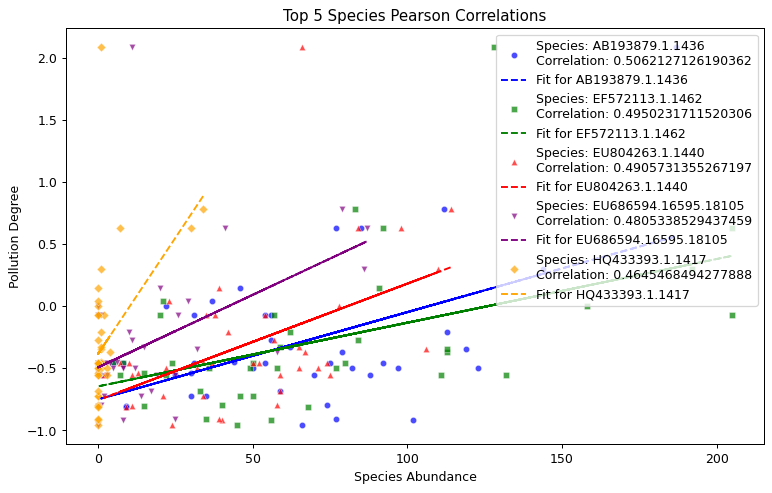

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def plot_line_of_best_fit(x, y, color, label):
    # Fit a first-degree polynomial (line) to the data
    slope, intercept = np.polyfit(x, y, 1)

    # Plot the line of best fit
    plt.plot(x, slope * np.array(x) + intercept, color=color, linestyle='--', label=f'Fit for {label}')

colors = ['blue', 'green', 'red', 'purple', 'orange']

markers = ['o', 's', '^', 'v', 'D']

plt.figure(figsize=(10, 6))

for i in range(min(5, len(sorted_coefficients))):
    row_index, correlation_coefficient = sorted_coefficients[i]
    one = domain[row_index]
    two = phylum[row_index]
    three = specie_class[row_index]
    four = order[row_index]
    five = family[row_index]
    six = genus[row_index]
    seven = specie[row_index]

    x_row_values = x_values[row_index]
    marker = markers[i]
    color = colors[i]

    sns.scatterplot(x=x_row_values, y=y_values, label=f'Species: {seven}\nCorrelation: {correlation_coefficient}',
                    color=color, marker=marker, alpha=0.7, s=25)

    plot_line_of_best_fit(x_row_values, y_values, color, label=seven)

plt.xlabel('Species Abundance')
plt.ylabel('Pollution Degree')
plt.title('Top 5 Species Pearson Correlations')
plt.legend()
plt.show()

#### Using Spearman Correlation

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.stats import spearmanr

# Load data
taxonomic_data = pd.read_csv('miTAG_taxonomic_filtered.tsv', delimiter='\t')
x_values = taxonomic_data.iloc[:, 7:].values

mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

release_df = pd.read_csv("TARA243.KO.profile.release", sep='\s+', skiprows=[1])

# Calculate t-value and probability distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

# Calculate Spearman correlation
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = spearmanr(x_values, y_values)
    return correlation_coefficient

# Degrees of freedom
degrees_of_freedom = 39

correlation_coefficients = {}

# Calculate correlation coefficients for each row
for row_index in range(len(release_df)):
    y_values = mapped_data[2].values
    x_row_values = x_values[row_index]
    correlation_coefficient = calculate_correlation(x_row_values, y_values)
    correlation_coefficients[row_index] = correlation_coefficient

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Extract taxonomic data
domain = taxonomic_data.iloc[:, 0].values
phylum = taxonomic_data.iloc[:, 1].values
specie_class = taxonomic_data.iloc[:, 2].values
order = taxonomic_data.iloc[:, 3].values
family = taxonomic_data.iloc[:, 4].values
genus = taxonomic_data.iloc[:, 5].values
specie = taxonomic_data.iloc[:, 6].values

with open("s_species_correlation.tab", "w") as file:
    file.write("Domain\tPhylum\tSpecies Class\tOrder\tFamily\tGenus\tSpecies\tCorrelation\tx\tProbability\n")

    for row_index, correlation_coefficient in sorted_coefficients:
        one = domain[row_index]
        two = phylum[row_index]
        three = specie_class[row_index]
        four = order[row_index]
        five = family[row_index]
        six = genus[row_index]
        seven = specie[row_index]

        x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        file.write(f"{one}\t{two}\t{three}\t{four}\t{five}\t{six}\t{seven}\t{correlation_coefficient}\t{x}\t{probability}\n")

In [ ]:
# Benjamini–Hochberg method
significant_rows = []

total_probability = 0

for row_index, correlation_coefficient in sorted_coefficients:
    one = domain[row_index]
    two = phylum[row_index]
    three = specie_class[row_index]
    four = order[row_index]
    five = family[row_index]
    six = genus[row_index]
    seven = specie[row_index]
    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    if total_probability + probability <= 1:
        significant_rows.append((row_index, seven, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

second_values = mapped_data[1].values
y_values = mapped_data[2].values

if significant_rows:
    significant_rows = significant_rows[:-1]

with open("s_significant_species.tab", "w") as file:
    for row_index, seven, correlation_coefficient, x, probability in significant_rows:
        one = domain[row_index]
        two = phylum[row_index]
        three = specie_class[row_index]
        four = order[row_index]
        five = family[row_index]
        six = genus[row_index]
        seven = specie[row_index]
        file.write(f"{one}\t{two}\t{three}\t{four}\t{five}\t{six}\t{seven}\t{correlation_coefficient}\t{probability}\n")
        # file.write(f"{one}\t{two}\t{three}\t{four}\t{five}\t{six}\t{seven}\t{correlation_coefficient}\t{probability}\t{x}\t{y_values}\n")


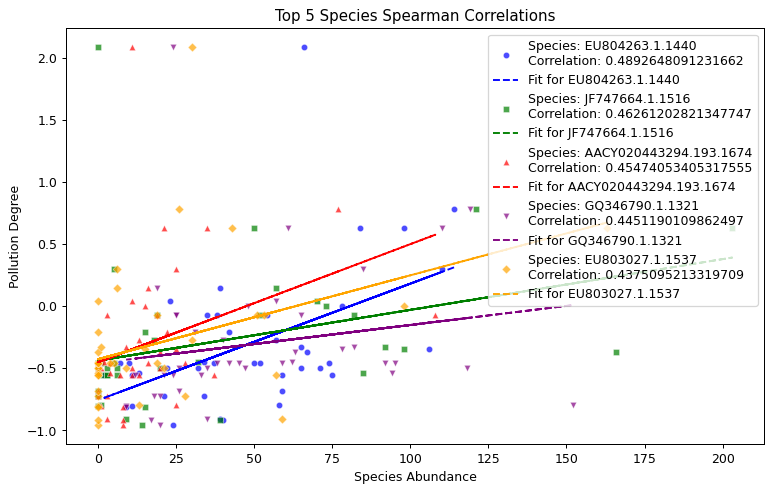

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def plot_line_of_best_fit(x, y, color, label):
    # Fit a first-degree polynomial (line) to the data
    slope, intercept = np.polyfit(x, y, 1)

    # Plot the line of best fit
    plt.plot(x, slope * np.array(x) + intercept, color=color, linestyle='--', label=f'Fit for {label}')

colors = ['blue', 'green', 'red', 'purple', 'orange']

markers = ['o', 's', '^', 'v', 'D']

plt.figure(figsize=(10, 6))

for i in range(min(5, len(sorted_coefficients))):
    row_index, correlation_coefficient = sorted_coefficients[i]
    one = domain[row_index]
    two = phylum[row_index]
    three = specie_class[row_index]
    four = order[row_index]
    five = family[row_index]
    six = genus[row_index]
    seven = specie[row_index]

    x_row_values = x_values[row_index]
    marker = markers[i]
    color = colors[i]

    sns.scatterplot(x=x_row_values, y=y_values, label=f'Species: {seven}\nCorrelation: {correlation_coefficient}',
                    color=color, marker=marker, alpha=0.7, s=25)

    plot_line_of_best_fit(x_row_values, y_values, color, label=seven)

plt.xlabel('Species Abundance')
plt.ylabel('Pollution Degree')
plt.title('Top 5 Species Spearman Correlations')
plt.legend()
plt.show()

# Cross-validation (5)

In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, t

# Function to calculate Pearson correlation coefficient
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - t.cdf(x, degrees_of_freedom)
    return x, probability

# Step 1: Load the mapped.txt file into a DataFrame
df = pd.read_csv("mapped.txt", header=None, delim_whitespace=True)

# Step 2: Randomly shuffle the samples (41 rows in total)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Split the 41 rows into 5 groups of 8, 8, 8, 8, and 9
rows_per_group = [8, 8, 8, 8, 9]  # Sizes of the groups
splits = []
start_idx = 0
for count in rows_per_group:
    splits.append(df_shuffled.iloc[start_idx:start_idx + count])
    start_idx += count

# Step 4: Generate all combinations of 4 groups out of the 5 groups
group_combinations = list(itertools.combinations(range(5), 4))  # Generate combinations of 4 out of 5 groups

# Step 5: Iterate over each group combination and process
for combo_index, combo in enumerate(group_combinations):
    # Combine the selected groups
    combined_rows = pd.concat([splits[i] for i in combo], ignore_index=True)

    # Save the combined group rows to a file
    group_file_name = f"cross-combo{combo_index + 1}.tab"
    combined_rows.to_csv(group_file_name, sep='\t', index=False, header=False)

    # Step 6: Load the enzyme abundance data (release file)
    release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

    # Step 7: Read the sample names and pollution values
    sample_names = combined_rows[1].values  # Sample names from the combination file
    y_values = combined_rows[2].values  # Pollution values from the combination file

    # Step 8: Create a dictionary of enzyme data from the TARA file
    tara_dict = release_df.set_index('ko').to_dict('index')

    # Step 9: Process the combined rows for correlation calculation
    x_values_for_all_enzymes = []  # List to store x_values for all enzymes for this combination

    # Step 10: Iterate over each enzyme in the TARA file
    for enzyme, enzyme_data in tara_dict.items():
        x_values = []

        # Extract x_values corresponding to the sample names in the current group
        for sample in sample_names:
            if sample in enzyme_data:
                x_values.append(enzyme_data[sample])
            else:
                x_values.append(np.nan)  # If the sample is not found, append NaN

        # Store the x_values along with the enzyme name for future output
        x_values_for_all_enzymes.append([enzyme] + x_values)

    # Step 11: Calculate the Pearson correlation for each enzyme
    correlation_results = []
    for enzyme_data in x_values_for_all_enzymes:
        enzyme_name = enzyme_data[0]
        x_values = enzyme_data[1:]

        # Calculate the correlation between x_values (enzyme abundance) and y_values (pollution values)
        correlation_coefficient = calculate_correlation(x_values, y_values)
        correlation_results.append((enzyme_name, correlation_coefficient))

    # Step 12: Sort the correlation coefficients in descending order
    correlation_results.sort(key=lambda x: x[1], reverse=True)

    # Step 13: Save the sorted correlation results to a file
    with open(f"cross-combo{combo_index + 1}_all_correlations.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient in correlation_results:
            degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
            t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

    # Step 14: Optionally calculate and save the t-value distribution for the correlations
    degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
    significant_rows = []
    total_probability = 0

    # Check the significance of each enzyme
    for enzyme_name, correlation_coefficient in correlation_results:
        t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        # Add the current result if the total probability does not exceed 1
        if total_probability + p_value <= 1:
            significant_rows.append((enzyme_name, correlation_coefficient, t_value, p_value))
            total_probability += p_value
        else:
            break

    # Step 15: Save the significant enzymes to a file
    with open(f"cross_sig_combo{combo_index + 1}.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient, t_value, p_value in significant_rows:
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")


In [ ]:
# Finding shared enzymes between cross combos and sig_pearson_enzymes
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Read the sig_pearson_enzymes.txt file (this is now in a specific format)
sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# List of cross_sig_combo files to process
group_files = [
    "cross_sig_combo1.tab",
    "cross_sig_combo2.tab",
    "cross_sig_combo3.tab",
    "cross_sig_combo4.tab",
    "cross_sig_combo5.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 6)]
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 6)])

# Calculate the percentage of common enzymes for each group
total_enzymes_in_sig = len(sig_enzymes)
for i in range(1, 6):
    group_column = f"Group{i} Correlation"
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()
    percentage_common = (common_enzymes_in_group / total_enzymes_in_sig) * 100 if total_enzymes_in_sig else 0
    df[f"Percentage Common in Group{i}"] = percentage_common

# Calculate the shared count (how many groups share each enzyme)
df["Shared Count"] = df[["Group1 Correlation", "Group2 Correlation", "Group3 Correlation", "Group4 Correlation", "Group5 Correlation"]].apply(lambda x: (x != "na").sum(), axis=1)

# Sort by the number of shared groups (from most to least)
df_sorted = df.sort_values(by="Shared Count", ascending=False)

# Drop the "Shared Count" column as it's just for sorting
df_sorted = df_sorted.drop(columns=["Shared Count"])

# Format the correlations to 2 decimal places for better readability
for group in ["Group1 Correlation", "Group2 Correlation", "Group3 Correlation", "Group4 Correlation", "Group5 Correlation"]:
    df_sorted[group] = df_sorted[group].apply(lambda x: f"{x:.2f}" if x != "na" else "na")

# Format the percentages to 2 decimal places for readability
for i in range(1, 6):
    df_sorted[f"Percentage Common in Group{i}"] = df_sorted[f"Percentage Common in Group{i}"].apply(lambda x: f"{x:.2f}%")

df_sorted.to_csv("cross_validation_results.tab", sep="\t", index=False)

In [ ]:
# Calculating percentage of shared enzymes by dividing by smaller number
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

group_files = [
    "cross_sig_combo1.tab",
    "cross_sig_combo2.tab",
    "cross_sig_combo3.tab",
    "cross_sig_combo4.tab",
    "cross_sig_combo5.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 6)]
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 6)])

# Calculate the percentage of common enzymes for each group
for i in range(1, 6):
    group_column = f"Group{i} Correlation"

    # Count the common enzymes in the current group
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()

    # Get the size of the current group and sig_enzymes
    total_enzymes_in_sig = len(sig_enzymes)
    total_enzymes_in_group = len(df)

    # Calculate the smaller number to divide by
    denominator = min(total_enzymes_in_sig, total_enzymes_in_group)

    # Calculate the percentage common
    percentage_common = (common_enzymes_in_group / denominator) * 100 if denominator else 0

    # Add the percentage common to the DataFrame
    df[f"Percentage Common in Group{i}"] = percentage_common

# Calculate the shared count (how many groups share each enzyme)
df["Shared Count"] = df[["Group1 Correlation", "Group2 Correlation", "Group3 Correlation", "Group4 Correlation", "Group5 Correlation"]].apply(lambda x: (x != "na").sum(), axis=1)

# Sort by the number of shared groups (from most to least)
df_sorted = df.sort_values(by="Shared Count", ascending=False)
df_sorted = df_sorted.drop(columns=["Shared Count"])

for group in ["Group1 Correlation", "Group2 Correlation", "Group3 Correlation", "Group4 Correlation", "Group5 Correlation"]:
    df_sorted[group] = df_sorted[group].apply(lambda x: f"{x:.2f}" if x != "na" else "na")

for i in range(1, 6):
    df_sorted[f"Percentage Common in Group{i}"] = df_sorted[f"Percentage Common in Group{i}"].apply(lambda x: f"{x:.2f}%")

df_sorted.to_csv("cross_validation_results.tab", sep="\t", index=False)

# Cross-validation (10)

In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, t

# Function to calculate Pearson correlation coefficient
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - t.cdf(x, degrees_of_freedom)
    return x, probability

# Step 1: Load the mapped.txt file into a DataFrame
df = pd.read_csv("mapped.txt", header=None, delim_whitespace=True)

# Step 2: Randomly shuffle the samples (41 rows in total)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Split the 41 rows into 10 groups with the specified sizes
rows_per_group = [4, 4, 4, 4, 4, 4, 4, 4, 4, 5]  # Sizes of the groups
splits = []
start_idx = 0
for count in rows_per_group:
    splits.append(df_shuffled.iloc[start_idx:start_idx + count])
    start_idx += count

# Step 4: Generate all combinations of 9 groups out of the 10 groups
group_combinations = list(itertools.combinations(range(10), 9))  # Generate combinations of 9 out of 10 groups

# Step 5: Iterate over each group combination and process
for combo_index, combo in enumerate(group_combinations):
    # Combine the selected groups
    combined_rows = pd.concat([splits[i] for i in combo], ignore_index=True)

    # Save the combined group rows to a file
    group_file_name = f"cross-combo{combo_index + 1}.tab"
    combined_rows.to_csv(group_file_name, sep='\t', index=False, header=False)

    # Step 6: Load the enzyme abundance data (release file)
    release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

    # Step 7: Read the sample names and pollution values
    sample_names = combined_rows[1].values  # Sample names from the combination file
    y_values = combined_rows[2].values  # Pollution values from the combination file

    # Step 8: Create a dictionary of enzyme data from the TARA file
    tara_dict = release_df.set_index('ko').to_dict('index')

    # Step 9: Process the combined rows for correlation calculation
    x_values_for_all_enzymes = []  # List to store x_values for all enzymes for this combination

    # Step 10: Iterate over each enzyme in the TARA file
    for enzyme, enzyme_data in tara_dict.items():
        x_values = []

        # Extract x_values corresponding to the sample names in the current group
        for sample in sample_names:
            if sample in enzyme_data:
                x_values.append(enzyme_data[sample])
            else:
                x_values.append(np.nan)  # If the sample is not found, append NaN

        # Store the x_values along with the enzyme name for future output
        x_values_for_all_enzymes.append([enzyme] + x_values)

    # Step 11: Calculate the Pearson correlation for each enzyme
    correlation_results = []
    for enzyme_data in x_values_for_all_enzymes:
        enzyme_name = enzyme_data[0]
        x_values = enzyme_data[1:]

        # Calculate the correlation between x_values (enzyme abundance) and y_values (pollution values)
        correlation_coefficient = calculate_correlation(x_values, y_values)
        correlation_results.append((enzyme_name, correlation_coefficient))

    # Step 12: Sort the correlation coefficients in descending order
    correlation_results.sort(key=lambda x: x[1], reverse=True)

    # Step 13: Save the sorted correlation results to a file
    with open(f"cross-combo{combo_index + 1}_all_correlations.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient in correlation_results:
            degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
            t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

    # Step 14: Optionally calculate and save the t-value distribution for the correlations
    degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
    significant_rows = []
    total_probability = 0

    # Check the significance of each enzyme
    for enzyme_name, correlation_coefficient in correlation_results:
        t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        # Add the current result if the total probability does not exceed 1
        if total_probability + p_value <= 1:
            significant_rows.append((enzyme_name, correlation_coefficient, t_value, p_value))
            total_probability += p_value
        else:
            break

    # Step 15: Save the significant enzymes to a file
    with open(f"cross_sig_combo{combo_index + 1}.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient, t_value, p_value in significant_rows:
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

In [ ]:
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Read the sig_pearson_enzymes.txt file (this is now in a specific format)
sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# List of cross_sig_combo files to process (updated to 10 groups)
group_files = [
    "cross_sig_combo1.tab",
    "cross_sig_combo2.tab",
    "cross_sig_combo3.tab",
    "cross_sig_combo4.tab",
    "cross_sig_combo5.tab",
    "cross_sig_combo6.tab",
    "cross_sig_combo7.tab",
    "cross_sig_combo8.tab",
    "cross_sig_combo9.tab",
    "cross_sig_combo10.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 11)]  # Update to 10 groups
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 11)])  # Update to 10 groups

# Calculate the percentage of common enzymes for each group
total_enzymes_in_sig = len(sig_enzymes)
for i in range(1, 11):  # Now loop over 10 groups
    group_column = f"Group{i} Correlation"
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()
    percentage_common = (common_enzymes_in_group / total_enzymes_in_sig) * 100 if total_enzymes_in_sig else 0
    df[f"Percentage Common in Group{i}"] = percentage_common

# Calculate the shared count (how many groups share each enzyme)
df["Shared Count"] = df[["Group1 Correlation", "Group2 Correlation", "Group3 Correlation", "Group4 Correlation", "Group5 Correlation",
                         "Group6 Correlation", "Group7 Correlation", "Group8 Correlation", "Group9 Correlation", "Group10 Correlation"]].apply(
    lambda x: (x != "na").sum(), axis=1)

# Sort by the number of shared groups (from most to least)
df_sorted = df.sort_values(by="Shared Count", ascending=False)

# Drop the "Shared Count" column as it's just for sorting
df_sorted = df_sorted.drop(columns=["Shared Count"])

# Format the correlations to 2 decimal places for better readability
for group in [f"Group{i} Correlation" for i in range(1, 11)]:  # Update to 10 groups
    df_sorted[group] = df_sorted[group].apply(lambda x: f"{x:.2f}" if x != "na" else "na")

# Format the percentages to 2 decimal places for readability
for i in range(1, 11):  # Update to 10 groups
    df_sorted[f"Percentage Common in Group{i}"] = df_sorted[f"Percentage Common in Group{i}"].apply(lambda x: f"{x:.2f}%")

# Save the results to a file
df_sorted.to_csv("10cross_validation_results.tab", sep="\t", index=False)


In [ ]:
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# Updated list of cross_sig_combo files for 10 groups
group_files = [
    "cross_sig_combo1.tab",
    "cross_sig_combo2.tab",
    "cross_sig_combo3.tab",
    "cross_sig_combo4.tab",
    "cross_sig_combo5.tab",
    "cross_sig_combo6.tab",
    "cross_sig_combo7.tab",
    "cross_sig_combo8.tab",
    "cross_sig_combo9.tab",
    "cross_sig_combo10.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 11)]  # Update for 10 groups
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 11)])  # Updated for 10 groups

# Calculate the percentage of common enzymes for each group
percentages = {}
for i in range(1, 11):  # Now looping over 10 groups
    group_column = f"Group{i} Correlation"

    # Count the common enzymes in the current group
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()

    # Get the size of the current group and sig_enzymes
    total_enzymes_in_sig = len(sig_enzymes)
    total_enzymes_in_group = len(df)

    # Calculate the smaller number to divide by
    denominator = min(total_enzymes_in_sig, total_enzymes_in_group)

    # Calculate the percentage common
    percentage_common = (common_enzymes_in_group / denominator) * 100 if denominator else 0

    # Store the percentage in the dictionary for output
    percentages[f"Group{i}"] = percentage_common

# Convert the percentages dictionary into a DataFrame
percentages_df = pd.DataFrame(list(percentages.items()), columns=["Group", "Percentage"])

# Format the percentages to 2 decimal places
percentages_df["Percentage"] = percentages_df["Percentage"].apply(lambda x: f"{x:.5f}%")

# Save the percentages to a separate file
percentages_df.to_csv("10_cross_validation_percentages.tab", sep="\t", index=False)


In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, t

# Function to calculate Pearson correlation coefficient
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - t.cdf(x, degrees_of_freedom)
    return x, probability

# Step 1: Load the mapped.txt file into a DataFrame
df = pd.read_csv("mapped.txt", header=None, delim_whitespace=True)

# Step 2: Define the specific order of rows (adjusted for 0-based indexing)
row_order = [
    38, 28, 33, 9, 0, 25, 14, 39, 23, 37, 15, 20, 11, 6, 32, 29, 21, 7, 36, 18,
    2, 10, 22, 13, 5, 40, 3, 8, 4, 24, 35, 16, 19, 27, 31, 17, 26, 34, 30, 12, 1
]

# Step 3: Reorder the rows according to the specific row order
df_ordered = df.iloc[row_order].reset_index(drop=True)

# Step 4: Split the 41 rows into 10 groups with the specified sizes
rows_per_group = [4, 4, 4, 4, 4, 4, 4, 4, 4, 5]  # Sizes of the groups
splits = []
start_idx = 0
for count in rows_per_group:
    splits.append(df_ordered.iloc[start_idx:start_idx + count])
    start_idx += count

# Step 5: Generate all combinations of 9 groups out of the 10 groups
group_combinations = list(itertools.combinations(range(10), 9))  # Generate combinations of 9 out of 10 groups

# Step 6: Iterate over each group combination and process
for combo_index, combo in enumerate(group_combinations):
    # Combine the selected groups
    combined_rows = pd.concat([splits[i] for i in combo], ignore_index=True)

    # Save the combined group rows to a file
    group_file_name = f"cross-combo{combo_index + 1}.tab"
    combined_rows.to_csv(group_file_name, sep='\t', index=False, header=False)

    # Step 7: Load the enzyme abundance data (release file)
    release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

    # Step 8: Read the sample names and pollution values
    sample_names = combined_rows[1].values  # Sample names from the combination file
    y_values = combined_rows[2].values  # Pollution values from the combination file

    # Step 9: Create a dictionary of enzyme data from the TARA file
    tara_dict = release_df.set_index('ko').to_dict('index')

    # Step 10: Process the combined rows for correlation calculation
    x_values_for_all_enzymes = []  # List to store x_values for all enzymes for this combination

    # Step 11: Iterate over each enzyme in the TARA file
    for enzyme, enzyme_data in tara_dict.items():
        x_values = []

        # Extract x_values corresponding to the sample names in the current group
        for sample in sample_names:
            if sample in enzyme_data:
                x_values.append(enzyme_data[sample])
            else:
                x_values.append(np.nan)  # If the sample is not found, append NaN

        # Store the x_values along with the enzyme name for future output
        x_values_for_all_enzymes.append([enzyme] + x_values)

    # Step 12: Calculate the Pearson correlation for each enzyme
    correlation_results = []
    for enzyme_data in x_values_for_all_enzymes:
        enzyme_name = enzyme_data[0]
        x_values = enzyme_data[1:]

        # Calculate the correlation between x_values (enzyme abundance) and y_values (pollution values)
        correlation_coefficient = calculate_correlation(x_values, y_values)
        correlation_results.append((enzyme_name, correlation_coefficient))

    # Step 13: Sort the correlation coefficients in descending order
    correlation_results.sort(key=lambda x: x[1], reverse=True)

    # Step 14: Save the sorted correlation results to a file
    with open(f"cross-combo{combo_index + 1}_all_correlations.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient in correlation_results:
            degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
            t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

    # Step 15: Optionally calculate and save the t-value distribution for the correlations
    degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
    significant_rows = []
    total_probability = 0

    # Check the significance of each enzyme
    for enzyme_name, correlation_coefficient in correlation_results:
        t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        # Add the current result if the total probability does not exceed 1
        if total_probability + p_value <= 1:
            significant_rows.append((enzyme_name, correlation_coefficient, t_value, p_value))
            total_probability += p_value
        else:
            break

    # Step 16: Save the significant enzymes to a file
    with open(f"1_10_cross_sig_combo{combo_index + 1}.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient, t_value, p_value in significant_rows:
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")


In [ ]:
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# Updated list of cross_sig_combo files for 10 groups
group_files = [
    "1_10_cross_sig_combo1.tab",
    "1_10_cross_sig_combo2.tab",
    "1_10_cross_sig_combo3.tab",
    "1_10_cross_sig_combo4.tab",
    "1_10_cross_sig_combo5.tab",
    "1_10_cross_sig_combo6.tab",
    "1_10_cross_sig_combo7.tab",
    "1_10_cross_sig_combo8.tab",
    "1_10_cross_sig_combo9.tab",
    "1_10_cross_sig_combo10.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 11)]  # Update for 10 groups
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 11)])  # Updated for 10 groups

# Calculate the percentage of common enzymes for each group
percentages = {}
for i in range(1, 11):  # Now looping over 10 groups
    group_column = f"Group{i} Correlation"

    # Count the common enzymes in the current group
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()

    # Get the size of the current group and sig_enzymes
    total_enzymes_in_sig = len(sig_enzymes)
    total_enzymes_in_group = len(df)

    # Calculate the smaller number to divide by
    denominator = min(total_enzymes_in_sig, total_enzymes_in_group)

    # Calculate the percentage common
    percentage_common = (common_enzymes_in_group / denominator) * 100 if denominator else 0

    # Store the percentage in the dictionary for output
    percentages[f"Group{i}"] = percentage_common

# Convert the percentages dictionary into a DataFrame
percentages_df = pd.DataFrame(list(percentages.items()), columns=["Group", "Percentage"])

# Format the percentages to 2 decimal places
percentages_df["Percentage"] = percentages_df["Percentage"].apply(lambda x: f"{x:.5f}%")

# Save the percentages to a separate file
percentages_df.to_csv("1_10_cross_validation_percentages.tab", sep="\t", index=False)


In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, t

# Function to calculate Pearson correlation coefficient
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - t.cdf(x, degrees_of_freedom)
    return x, probability

# Step 1: Load the mapped.txt file into a DataFrame
df = pd.read_csv("mapped.txt", header=None, delim_whitespace=True)

# Step 2: Define the specific order of rows (adjusted for 0-based indexing)
row_order = [
    26, 6, 19, 23, 15, 18, 1, 0, 12, 25, 34, 30, 35, 16, 29, 10, 2, 24, 13, 28,
    32, 31, 36, 7, 8, 40, 11, 9, 17, 22, 3, 4, 27, 20, 14, 39, 5, 38, 21, 37, 33
]

# Step 3: Reorder the rows according to the specific row order
df_ordered = df.iloc[row_order].reset_index(drop=True)

# Step 4: Split the 41 rows into 10 groups with the specified sizes
rows_per_group = [4, 4, 4, 4, 4, 4, 4, 4, 4, 5]  # Sizes of the groups
splits = []
start_idx = 0
for count in rows_per_group:
    splits.append(df_ordered.iloc[start_idx:start_idx + count])
    start_idx += count

# Step 5: Generate all combinations of 9 groups out of the 10 groups
group_combinations = list(itertools.combinations(range(10), 9))  # Generate combinations of 9 out of 10 groups

# Step 6: Iterate over each group combination and process
for combo_index, combo in enumerate(group_combinations):
    # Combine the selected groups
    combined_rows = pd.concat([splits[i] for i in combo], ignore_index=True)

    # Save the combined group rows to a file
    group_file_name = f"cross-combo{combo_index + 1}.tab"
    combined_rows.to_csv(group_file_name, sep='\t', index=False, header=False)

    # Step 7: Load the enzyme abundance data (release file)
    release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

    # Step 8: Read the sample names and pollution values
    sample_names = combined_rows[1].values  # Sample names from the combination file
    y_values = combined_rows[2].values  # Pollution values from the combination file

    # Step 9: Create a dictionary of enzyme data from the TARA file
    tara_dict = release_df.set_index('ko').to_dict('index')

    # Step 10: Process the combined rows for correlation calculation
    x_values_for_all_enzymes = []  # List to store x_values for all enzymes for this combination

    # Step 11: Iterate over each enzyme in the TARA file
    for enzyme, enzyme_data in tara_dict.items():
        x_values = []

        # Extract x_values corresponding to the sample names in the current group
        for sample in sample_names:
            if sample in enzyme_data:
                x_values.append(enzyme_data[sample])
            else:
                x_values.append(np.nan)  # If the sample is not found, append NaN

        # Store the x_values along with the enzyme name for future output
        x_values_for_all_enzymes.append([enzyme] + x_values)

    # Step 12: Calculate the Pearson correlation for each enzyme
    correlation_results = []
    for enzyme_data in x_values_for_all_enzymes:
        enzyme_name = enzyme_data[0]
        x_values = enzyme_data[1:]

        # Calculate the correlation between x_values (enzyme abundance) and y_values (pollution values)
        correlation_coefficient = calculate_correlation(x_values, y_values)
        correlation_results.append((enzyme_name, correlation_coefficient))

    # Step 13: Sort the correlation coefficients in descending order
    correlation_results.sort(key=lambda x: x[1], reverse=True)

    # Step 14: Save the sorted correlation results to a file
    with open(f"cross-combo{combo_index + 1}_all_correlations.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient in correlation_results:
            degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
            t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

    # Step 15: Optionally calculate and save the t-value distribution for the correlations
    degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
    significant_rows = []
    total_probability = 0

    # Check the significance of each enzyme
    for enzyme_name, correlation_coefficient in correlation_results:
        t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        # Add the current result if the total probability does not exceed 1
        if total_probability + p_value <= 1:
            significant_rows.append((enzyme_name, correlation_coefficient, t_value, p_value))
            total_probability += p_value
        else:
            break

    # Step 16: Save the significant enzymes to a file
    with open(f"2_10_cross_sig_combo{combo_index + 1}.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient, t_value, p_value in significant_rows:
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")


In [ ]:
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# Updated list of cross_sig_combo files for 10 groups
group_files = [
    "2_10_cross_sig_combo1.tab",
    "2_10_cross_sig_combo2.tab",
    "2_10_cross_sig_combo3.tab",
    "2_10_cross_sig_combo4.tab",
    "2_10_cross_sig_combo5.tab",
    "2_10_cross_sig_combo6.tab",
    "2_10_cross_sig_combo7.tab",
    "2_10_cross_sig_combo8.tab",
    "2_10_cross_sig_combo9.tab",
    "2_10_cross_sig_combo10.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 11)]  # Update for 10 groups
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 11)])  # Updated for 10 groups

# Calculate the percentage of common enzymes for each group
percentages = {}
for i in range(1, 11):  # Now looping over 10 groups
    group_column = f"Group{i} Correlation"

    # Count the common enzymes in the current group
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()

    # Get the size of the current group and sig_enzymes
    total_enzymes_in_sig = len(sig_enzymes)
    total_enzymes_in_group = len(df)

    # Calculate the smaller number to divide by
    denominator = min(total_enzymes_in_sig, total_enzymes_in_group)

    # Calculate the percentage common
    percentage_common = (common_enzymes_in_group / denominator) * 100 if denominator else 0

    # Store the percentage in the dictionary for output
    percentages[f"Group{i}"] = percentage_common

# Convert the percentages dictionary into a DataFrame
percentages_df = pd.DataFrame(list(percentages.items()), columns=["Group", "Percentage"])

# Format the percentages to 2 decimal places
percentages_df["Percentage"] = percentages_df["Percentage"].apply(lambda x: f"{x:.5f}%")

# Save the percentages to a separate file
percentages_df.to_csv("2_10_cross_validation_percentages.tab", sep="\t", index=False)


In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, t

# Function to calculate Pearson correlation coefficient
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - t.cdf(x, degrees_of_freedom)
    return x, probability

# Step 1: Load the mapped.txt file into a DataFrame
df = pd.read_csv("mapped.txt", header=None, delim_whitespace=True)

# Step 2: Define the specific order of rows (adjusted for 0-based indexing)
row_order = [
    37, 15, 14, 1, 0, 2, 8, 16, 19, 30, 4, 34, 26, 11, 20, 7, 3, 33, 29, 28,
    36, 32, 9, 13, 18, 22, 25, 31, 17, 5, 27, 40, 23, 38, 10, 6, 24, 39, 21, 35, 12
]

# Step 3: Reorder the rows according to the specific row order
df_ordered = df.iloc[row_order].reset_index(drop=True)

# Step 4: Split the 41 rows into 10 groups with the specified sizes
rows_per_group = [4, 4, 4, 4, 4, 4, 4, 4, 4, 5]  # Sizes of the groups
splits = []
start_idx = 0
for count in rows_per_group:
    splits.append(df_ordered.iloc[start_idx:start_idx + count])
    start_idx += count

# Step 5: Generate all combinations of 9 groups out of the 10 groups
group_combinations = list(itertools.combinations(range(10), 9))  # Generate combinations of 9 out of 10 groups

# Step 6: Iterate over each group combination and process
for combo_index, combo in enumerate(group_combinations):
    # Combine the selected groups
    combined_rows = pd.concat([splits[i] for i in combo], ignore_index=True)

    # Save the combined group rows to a file
    group_file_name = f"cross-combo{combo_index + 1}.tab"
    combined_rows.to_csv(group_file_name, sep='\t', index=False, header=False)

    # Step 7: Load the enzyme abundance data (release file)
    release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

    # Step 8: Read the sample names and pollution values
    sample_names = combined_rows[1].values  # Sample names from the combination file
    y_values = combined_rows[2].values  # Pollution values from the combination file

    # Step 9: Create a dictionary of enzyme data from the TARA file
    tara_dict = release_df.set_index('ko').to_dict('index')

    # Step 10: Process the combined rows for correlation calculation
    x_values_for_all_enzymes = []  # List to store x_values for all enzymes for this combination

    # Step 11: Iterate over each enzyme in the TARA file
    for enzyme, enzyme_data in tara_dict.items():
        x_values = []

        # Extract x_values corresponding to the sample names in the current group
        for sample in sample_names:
            if sample in enzyme_data:
                x_values.append(enzyme_data[sample])
            else:
                x_values.append(np.nan)  # If the sample is not found, append NaN

        # Store the x_values along with the enzyme name for future output
        x_values_for_all_enzymes.append([enzyme] + x_values)

    # Step 12: Calculate the Pearson correlation for each enzyme
    correlation_results = []
    for enzyme_data in x_values_for_all_enzymes:
        enzyme_name = enzyme_data[0]
        x_values = enzyme_data[1:]

        # Calculate the correlation between x_values (enzyme abundance) and y_values (pollution values)
        correlation_coefficient = calculate_correlation(x_values, y_values)
        correlation_results.append((enzyme_name, correlation_coefficient))

    # Step 13: Sort the correlation coefficients in descending order
    correlation_results.sort(key=lambda x: x[1], reverse=True)

    # Step 14: Save the sorted correlation results to a file
    with open(f"cross-combo{combo_index + 1}_all_correlations.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient in correlation_results:
            degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
            t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

    # Step 15: Optionally calculate and save the t-value distribution for the correlations
    degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
    significant_rows = []
    total_probability = 0

    # Check the significance of each enzyme
    for enzyme_name, correlation_coefficient in correlation_results:
        t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        # Add the current result if the total probability does not exceed 1
        if total_probability + p_value <= 1:
            significant_rows.append((enzyme_name, correlation_coefficient, t_value, p_value))
            total_probability += p_value
        else:
            break

    # Step 16: Save the significant enzymes to a file
    with open(f"3_10_cross_sig_combo{combo_index + 1}.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient, t_value, p_value in significant_rows:
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")


In [ ]:
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# Updated list of cross_sig_combo files for 10 groups
group_files = [
    "3_10_cross_sig_combo1.tab",
    "3_10_cross_sig_combo2.tab",
    "3_10_cross_sig_combo3.tab",
    "3_10_cross_sig_combo4.tab",
    "3_10_cross_sig_combo5.tab",
    "3_10_cross_sig_combo6.tab",
    "3_10_cross_sig_combo7.tab",
    "3_10_cross_sig_combo8.tab",
    "3_10_cross_sig_combo9.tab",
    "3_10_cross_sig_combo10.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 11)]  # Update for 10 groups
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 11)])  # Updated for 10 groups

# Calculate the percentage of common enzymes for each group
percentages = {}
for i in range(1, 11):  # Now looping over 10 groups
    group_column = f"Group{i} Correlation"

    # Count the common enzymes in the current group
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()

    # Get the size of the current group and sig_enzymes
    total_enzymes_in_sig = len(sig_enzymes)
    total_enzymes_in_group = len(df)

    # Calculate the smaller number to divide by
    denominator = min(total_enzymes_in_sig, total_enzymes_in_group)

    # Calculate the percentage common
    percentage_common = (common_enzymes_in_group / denominator) * 100 if denominator else 0

    # Store the percentage in the dictionary for output
    percentages[f"Group{i}"] = percentage_common

# Convert the percentages dictionary into a DataFrame
percentages_df = pd.DataFrame(list(percentages.items()), columns=["Group", "Percentage"])

# Format the percentages to 2 decimal places
percentages_df["Percentage"] = percentages_df["Percentage"].apply(lambda x: f"{x:.5f}%")

# Save the percentages to a separate file
percentages_df.to_csv("3_10_cross_validation_percentages.tab", sep="\t", index=False)


In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, t

# Function to calculate Pearson correlation coefficient
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - t.cdf(x, degrees_of_freedom)
    return x, probability

# Step 1: Load the mapped.txt file into a DataFrame
df = pd.read_csv("mapped.txt", header=None, delim_whitespace=True)

# Step 2: Define the specific order of rows (adjusted for 0-based indexing)
row_order = [
    6, 35, 39, 8, 26, 14, 5, 3, 12, 37, 24, 40, 30,
    13, 4, 29, 19, 28, 9, 7, 0, 27, 11, 15, 18, 22, 1, 17, 20,
    32, 33, 36, 23, 34, 16, 31, 10, 2, 38, 25, 21
 ]

# Step 3: Reorder the rows according to the specific row order
df_ordered = df.iloc[row_order].reset_index(drop=True)

# Step 4: Split the 41 rows into 10 groups with the specified sizes
rows_per_group = [4, 4, 4, 4, 4, 4, 4, 4, 4, 5]  # Sizes of the groups
splits = []
start_idx = 0
for count in rows_per_group:
    splits.append(df_ordered.iloc[start_idx:start_idx + count])
    start_idx += count

# Step 5: Generate all combinations of 9 groups out of the 10 groups
group_combinations = list(itertools.combinations(range(10), 9))  # Generate combinations of 9 out of 10 groups

# Step 6: Iterate over each group combination and process
for combo_index, combo in enumerate(group_combinations):
    # Combine the selected groups
    combined_rows = pd.concat([splits[i] for i in combo], ignore_index=True)

    # Save the combined group rows to a file
    group_file_name = f"cross-combo{combo_index + 1}.tab"
    combined_rows.to_csv(group_file_name, sep='\t', index=False, header=False)

    # Step 7: Load the enzyme abundance data (release file)
    release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

    # Step 8: Read the sample names and pollution values
    sample_names = combined_rows[1].values  # Sample names from the combination file
    y_values = combined_rows[2].values  # Pollution values from the combination file

    # Step 9: Create a dictionary of enzyme data from the TARA file
    tara_dict = release_df.set_index('ko').to_dict('index')

    # Step 10: Process the combined rows for correlation calculation
    x_values_for_all_enzymes = []  # List to store x_values for all enzymes for this combination

    # Step 11: Iterate over each enzyme in the TARA file
    for enzyme, enzyme_data in tara_dict.items():
        x_values = []

        # Extract x_values corresponding to the sample names in the current group
        for sample in sample_names:
            if sample in enzyme_data:
                x_values.append(enzyme_data[sample])
            else:
                x_values.append(np.nan)  # If the sample is not found, append NaN

        # Store the x_values along with the enzyme name for future output
        x_values_for_all_enzymes.append([enzyme] + x_values)

    # Step 12: Calculate the Pearson correlation for each enzyme
    correlation_results = []
    for enzyme_data in x_values_for_all_enzymes:
        enzyme_name = enzyme_data[0]
        x_values = enzyme_data[1:]

        # Calculate the correlation between x_values (enzyme abundance) and y_values (pollution values)
        correlation_coefficient = calculate_correlation(x_values, y_values)
        correlation_results.append((enzyme_name, correlation_coefficient))

    # Step 13: Sort the correlation coefficients in descending order
    correlation_results.sort(key=lambda x: x[1], reverse=True)

    # Step 14: Save the sorted correlation results to a file
    with open(f"cross-combo{combo_index + 1}_all_correlations.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient in correlation_results:
            degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
            t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

    # Step 15: Optionally calculate and save the t-value distribution for the correlations
    degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
    significant_rows = []
    total_probability = 0

    # Check the significance of each enzyme
    for enzyme_name, correlation_coefficient in correlation_results:
        t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        # Add the current result if the total probability does not exceed 1
        if total_probability + p_value <= 1:
            significant_rows.append((enzyme_name, correlation_coefficient, t_value, p_value))
            total_probability += p_value
        else:
            break

    # Step 16: Save the significant enzymes to a file
    with open(f"4_10_cross_sig_combo{combo_index + 1}.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient, t_value, p_value in significant_rows:
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")


In [ ]:
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# Updated list of cross_sig_combo files for 10 groups
group_files = [
    "4_10_cross_sig_combo1.tab",
    "4_10_cross_sig_combo2.tab",
    "4_10_cross_sig_combo3.tab",
    "4_10_cross_sig_combo4.tab",
    "4_10_cross_sig_combo5.tab",
    "4_10_cross_sig_combo6.tab",
    "4_10_cross_sig_combo7.tab",
    "4_10_cross_sig_combo8.tab",
    "4_10_cross_sig_combo9.tab",
    "4_10_cross_sig_combo10.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 11)]  # Update for 10 groups
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 11)])  # Updated for 10 groups

# Calculate the percentage of common enzymes for each group
percentages = {}
for i in range(1, 11):  # Now looping over 10 groups
    group_column = f"Group{i} Correlation"

    # Count the common enzymes in the current group
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()

    # Get the size of the current group and sig_enzymes
    total_enzymes_in_sig = len(sig_enzymes)
    total_enzymes_in_group = len(df)

    # Calculate the smaller number to divide by
    denominator = min(total_enzymes_in_sig, total_enzymes_in_group)

    # Calculate the percentage common
    percentage_common = (common_enzymes_in_group / denominator) * 100 if denominator else 0

    # Store the percentage in the dictionary for output
    percentages[f"Group{i}"] = percentage_common

# Convert the percentages dictionary into a DataFrame
percentages_df = pd.DataFrame(list(percentages.items()), columns=["Group", "Percentage"])

# Format the percentages to 2 decimal places
percentages_df["Percentage"] = percentages_df["Percentage"].apply(lambda x: f"{x:.5f}%")

# Save the percentages to a separate file
percentages_df.to_csv("4_10_cross_validation_percentages.tab", sep="\t", index=False)


In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, t

# Function to calculate Pearson correlation coefficient
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - t.cdf(x, degrees_of_freedom)
    return x, probability

# Step 1: Load the mapped.txt file into a DataFrame
df = pd.read_csv("mapped.txt", header=None, delim_whitespace=True)

# Step 2: Define the specific order of rows (adjusted for 0-based indexing)
row_order = [
    17, 32, 31, 7, 6, 26, 8, 19, 28, 10, 1, 33, 35, 2,
    14, 5, 34, 39, 22, 4, 13, 21, 38, 18, 16, 0, 9, 12, 15,
    27, 23, 36, 3, 37, 20, 11, 40, 25, 24, 30, 29
 ]

# Step 3: Reorder the rows according to the specific row order
df_ordered = df.iloc[row_order].reset_index(drop=True)

# Step 4: Split the 41 rows into 10 groups with the specified sizes
rows_per_group = [4, 4, 4, 4, 4, 4, 4, 4, 4, 5]  # Sizes of the groups
splits = []
start_idx = 0
for count in rows_per_group:
    splits.append(df_ordered.iloc[start_idx:start_idx + count])
    start_idx += count

# Step 5: Generate all combinations of 9 groups out of the 10 groups
group_combinations = list(itertools.combinations(range(10), 9))  # Generate combinations of 9 out of 10 groups

# Step 6: Iterate over each group combination and process
for combo_index, combo in enumerate(group_combinations):
    # Combine the selected groups
    combined_rows = pd.concat([splits[i] for i in combo], ignore_index=True)

    # Save the combined group rows to a file
    group_file_name = f"cross-combo{combo_index + 1}.tab"
    combined_rows.to_csv(group_file_name, sep='\t', index=False, header=False)

    # Step 7: Load the enzyme abundance data (release file)
    release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

    # Step 8: Read the sample names and pollution values
    sample_names = combined_rows[1].values  # Sample names from the combination file
    y_values = combined_rows[2].values  # Pollution values from the combination file

    # Step 9: Create a dictionary of enzyme data from the TARA file
    tara_dict = release_df.set_index('ko').to_dict('index')

    # Step 10: Process the combined rows for correlation calculation
    x_values_for_all_enzymes = []  # List to store x_values for all enzymes for this combination

    # Step 11: Iterate over each enzyme in the TARA file
    for enzyme, enzyme_data in tara_dict.items():
        x_values = []

        # Extract x_values corresponding to the sample names in the current group
        for sample in sample_names:
            if sample in enzyme_data:
                x_values.append(enzyme_data[sample])
            else:
                x_values.append(np.nan)  # If the sample is not found, append NaN

        # Store the x_values along with the enzyme name for future output
        x_values_for_all_enzymes.append([enzyme] + x_values)

    # Step 12: Calculate the Pearson correlation for each enzyme
    correlation_results = []
    for enzyme_data in x_values_for_all_enzymes:
        enzyme_name = enzyme_data[0]
        x_values = enzyme_data[1:]

        # Calculate the correlation between x_values (enzyme abundance) and y_values (pollution values)
        correlation_coefficient = calculate_correlation(x_values, y_values)
        correlation_results.append((enzyme_name, correlation_coefficient))

    # Step 13: Sort the correlation coefficients in descending order
    correlation_results.sort(key=lambda x: x[1], reverse=True)

    # Step 14: Save the sorted correlation results to a file
    with open(f"cross-combo{combo_index + 1}_all_correlations.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient in correlation_results:
            degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
            t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")

    # Step 15: Optionally calculate and save the t-value distribution for the correlations
    degrees_of_freedom = len(combined_rows) - 2  # Adjust degrees of freedom based on current group size
    significant_rows = []
    total_probability = 0

    # Check the significance of each enzyme
    for enzyme_name, correlation_coefficient in correlation_results:
        t_value, p_value = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        # Add the current result if the total probability does not exceed 1
        if total_probability + p_value <= 1:
            significant_rows.append((enzyme_name, correlation_coefficient, t_value, p_value))
            total_probability += p_value
        else:
            break

    # Step 16: Save the significant enzymes to a file
    with open(f"5_10_cross_sig_combo{combo_index + 1}.tab", "w") as file:
        file.write("Enzyme\tCorrelation\tT-dist\tP-value\n")
        for enzyme_name, correlation_coefficient, t_value, p_value in significant_rows:
            file.write(f"{enzyme_name}\t{correlation_coefficient}\t{t_value}\t{p_value}\n")


In [ ]:
import pandas as pd

# Function to read the enzyme data from the sig_pearson_enzymes.txt file
def read_sig_pearson_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(", ")
                enzyme_name = parts[0].split(" = ")[1]
                correlation = float(parts[1].split(" = ")[1])
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

# Function to read the enzyme data from cross_sig_combo files
def read_cross_sig_file(file_name):
    enzyme_data = {}
    with open(file_name, "r") as file:
        next(file)  # Skip the header row
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split("\t")
                enzyme_name = parts[0]  # Enzyme name is in the first column
                correlation = float(parts[1])  # Correlation is in the second column
                enzyme_data[enzyme_name] = correlation
    return enzyme_data

sig_enzymes = read_sig_pearson_file("sig_pearson_enzymes.txt")

# Updated list of cross_sig_combo files for 10 groups
group_files = [
    "5_10_cross_sig_combo1.tab",
    "5_10_cross_sig_combo2.tab",
    "5_10_cross_sig_combo3.tab",
    "5_10_cross_sig_combo4.tab",
    "5_10_cross_sig_combo5.tab",
    "5_10_cross_sig_combo6.tab",
    "5_10_cross_sig_combo7.tab",
    "5_10_cross_sig_combo8.tab",
    "5_10_cross_sig_combo9.tab",
    "5_10_cross_sig_combo10.tab"
]

# Create a dictionary to store which groups share which enzymes
shared_enzyme_data = {}

# Process each cross_sig_combo file
for i, group_file in enumerate(group_files, start=1):
    group_enzymes = read_cross_sig_file(group_file)
    for enzyme_name in group_enzymes:
        if enzyme_name in sig_enzymes:  # Only consider enzymes that are shared between sig_pearson and the current group
            if enzyme_name not in shared_enzyme_data:
                shared_enzyme_data[enzyme_name] = {"Enzyme Name": enzyme_name}

            # Add the correlation for the specific group
            shared_enzyme_data[enzyme_name][f"Group{i} Correlation"] = group_enzymes[enzyme_name]

# Convert shared enzyme data into a DataFrame
final_data = []
for enzyme_name, group_data in shared_enzyme_data.items():
    row = [enzyme_name] + [group_data.get(f"Group{i} Correlation", "na") for i in range(1, 11)]  # Update for 10 groups
    final_data.append(row)

# Create DataFrame
df = pd.DataFrame(final_data, columns=["Enzyme Name"] + [f"Group{i} Correlation" for i in range(1, 11)])  # Updated for 10 groups

# Calculate the percentage of common enzymes for each group
percentages = {}
for i in range(1, 11):  # Now looping over 10 groups
    group_column = f"Group{i} Correlation"

    # Count the common enzymes in the current group
    common_enzymes_in_group = df[group_column].apply(lambda x: x != "na").sum()

    # Get the size of the current group and sig_enzymes
    total_enzymes_in_sig = len(sig_enzymes)
    total_enzymes_in_group = len(df)

    # Calculate the smaller number to divide by
    denominator = min(total_enzymes_in_sig, total_enzymes_in_group)

    # Calculate the percentage common
    percentage_common = (common_enzymes_in_group / denominator) * 100 if denominator else 0

    # Store the percentage in the dictionary for output
    percentages[f"Group{i}"] = percentage_common

# Convert the percentages dictionary into a DataFrame
percentages_df = pd.DataFrame(list(percentages.items()), columns=["Group", "Percentage"])

# Format the percentages to 2 decimal places
percentages_df["Percentage"] = percentages_df["Percentage"].apply(lambda x: f"{x:.5f}%")

# Save the percentages to a separate file
percentages_df.to_csv("5_10_cross_validation_percentages.tab", sep="\t", index=False)


# Confidence Interval

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.stats import pearsonr

# Function to calculate correlation
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

# Degrees of freedom for the t-distribution
degrees_of_freedom = 39

# Load the enzyme abundance data (release file)
release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

# Load the mapped data with corresponding pollution values
mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values (sample IDs) and y values (pollution values)
second_values = mapped_data[1].values
y_values = mapped_data[2].values

# Dictionary to store correlation coefficients and x values for each enzyme
correlation_coefficients = {}
x_values_for_all_enzymes = []  # List to store x_values for all enzymes

# Iterate over each row of the enzyme abundance data
for row_index in range(len(release_df)):
    # Extract the x_values corresponding to each sample (second_value)
    x_values = [release_df.iloc[row_index][str(second_value)] for second_value in second_values]

    # Resize y_values to match the length of x_values
    desired_length = len(x_values)
    y_values_resized = np.resize(y_values, desired_length)

    # Calculate the correlation coefficient for this enzyme
    correlation_coefficient = calculate_correlation(x_values, y_values_resized)
    correlation_coefficients[row_index] = correlation_coefficient

    # Store the x_values along with the enzyme name for future output
    enzyme_name = release_df.iloc[row_index, 0]  # Assuming the first column contains enzyme names
    x_values_for_all_enzymes.append([enzyme_name] + x_values)

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Create a list of the first column values (enzyme names) from the release file
first_column_values = release_df.iloc[:, 0].values

# Now calculate the t-value and p-value for the sorted coefficients and prepare for output
significant_rows = []
total_probability = 0

for row_index, correlation_coefficient in sorted_coefficients:
    first_value = first_column_values[row_index]  # Get the corresponding enzyme name
    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    # Check if adding the current probability exceeds 1
    if total_probability + probability <= 1:
        significant_rows.append((row_index, first_value, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

# Write the results to sig_pearson_enzymes.txt
with open("sig_pearson_enzymes.txt", "w") as file:
    for row_index, first_value, correlation_coefficient, x, probability in significant_rows:
        file.write(f"Enzyme = {first_value}, Correlation = {correlation_coefficient}, t-dist = {x}, p-value = {probability}\n")


In [ ]:
import numpy as np
import scipy.stats as stats

# Function to perform Fisher's transformation
def fisher_z_transformation(correlation_coefficient):
    return 0.5 * np.log((1 + correlation_coefficient) / (1 - correlation_coefficient))

# Function to calculate confidence interval for correlation
def calculate_confidence_interval(correlation_coefficient, degrees_of_freedom, confidence_level=0.95):
    # Step 1: Apply Fisher's transformation
    z = fisher_z_transformation(correlation_coefficient)

    # Step 2: Calculate the standard error (SE)
    n = degrees_of_freedom + 2  # Sample size (degrees of freedom + 2)
    se = 1 / np.sqrt(n - 3)

    # Step 3: Calculate the Z-value for the confidence level
    alpha = 1 - confidence_level
    z_alpha = stats.norm.ppf(1 - alpha / 2)  # Z value for confidence level (e.g., 1.96 for 95% CI)

    # Step 4: Compute the confidence interval in the Fisher transformed space
    z_lower = z - z_alpha * se
    z_upper = z + z_alpha * se

    # Step 5: Back-transform the Z interval to get the correlation coefficient interval
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)

    return r_lower, r_upper

significant_rows = []
with open("sig_pearson_enzymes.txt", "r") as file:
    for line in file:
        # Parse the enzyme name, correlation coefficient, and t-dist values
        parts = line.strip().split(", ")
        enzyme_name = parts[0].split(" = ")[1]
        correlation = float(parts[1].split(" = ")[1])
        t_value = float(parts[2].split(" = ")[1].split()[0])
        p_value = float(parts[3].split(" = ")[1])

        significant_rows.append((enzyme_name, correlation, t_value, p_value))

# Calculate the confidence intervals and store the results
confidence_intervals = []
for enzyme_name, correlation, t_value, p_value in significant_rows:
    df = 39

    # Calculate the confidence interval for this enzyme's correlation coefficient
    r_lower, r_upper = calculate_confidence_interval(correlation, df)

    confidence_intervals.append((enzyme_name, correlation, r_lower, r_upper, t_value, p_value))

# Write to a .tab file with header
with open("confidence_intervals_pearson.tab", "w") as file:
    # Write header row
    file.write("Enzyme\tCorrelation\t95% CI Lower\t95% CI Upper\tt-dist (x value)\tp-value\n")

    # Write data rows without "Enzyme = " etc.
    for enzyme_name, correlation, r_lower, r_upper, t_value, p_value in confidence_intervals:
        # Using tabs as separators instead of the " = " syntax
        file.write(f"{enzyme_name}\t{correlation}\t{r_lower}\t{r_upper}\t{t_value}\t{p_value}\n")

### Confidence Interval (Spearman)

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.stats import spearmanr

# Function to calculate correlation
def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = spearmanr(x_values, y_values)
    return correlation_coefficient

# Function to calculate t-value distribution
def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    x = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(x, degrees_of_freedom)
    return x, probability

# Degrees of freedom for the t-distribution
degrees_of_freedom = 39

# Load the enzyme abundance data (release file)
release_df = pd.read_csv("TARA243.KO.profile.release", delim_whitespace=True, skiprows=[1])

# Load the mapped data with corresponding pollution values
mapped_data = pd.read_csv('mapped.txt', sep='\t', header=None)

# Read all the second values (sample IDs) and y values (pollution values)
second_values = mapped_data[1].values
y_values = mapped_data[2].values

# Dictionary to store correlation coefficients and x values for each enzyme
correlation_coefficients = {}
x_values_for_all_enzymes = []  # List to store x_values for all enzymes

# Iterate over each row of the enzyme abundance data
for row_index in range(len(release_df)):
    # Extract the x_values corresponding to each sample (second_value)
    x_values = [release_df.iloc[row_index][str(second_value)] for second_value in second_values]

    # Resize y_values to match the length of x_values
    desired_length = len(x_values)
    y_values_resized = np.resize(y_values, desired_length)

    # Calculate the correlation coefficient for this enzyme
    correlation_coefficient = calculate_correlation(x_values, y_values_resized)
    correlation_coefficients[row_index] = correlation_coefficient

    # Store the x_values along with the enzyme name for future output
    enzyme_name = release_df.iloc[row_index, 0]  # Assuming the first column contains enzyme names
    x_values_for_all_enzymes.append([enzyme_name] + x_values)

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Create a list of the first column values (enzyme names) from the release file
first_column_values = release_df.iloc[:, 0].values

# Now calculate the t-value and p-value for the sorted coefficients and prepare for output
significant_rows = []
total_probability = 0

for row_index, correlation_coefficient in sorted_coefficients:
    first_value = first_column_values[row_index]  # Get the corresponding enzyme name
    x, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

    # Check if adding the current probability exceeds 1
    if total_probability + probability <= 1:
        significant_rows.append((row_index, first_value, correlation_coefficient, x, probability))
        total_probability += probability
    else:
        break

with open("sig_spearman_enzymes.txt", "w") as file:
    for row_index, first_value, correlation_coefficient, x, probability in significant_rows:
        file.write(f"Enzyme = {first_value}, Correlation = {correlation_coefficient}, t-dist = {x}, p-value = {probability}\n")


In [ ]:
import numpy as np
import scipy.stats as stats

# Function to perform Fisher's transformation
def fisher_z_transformation(correlation_coefficient):
    return 0.5 * np.log((1 + correlation_coefficient) / (1 - correlation_coefficient))

# Function to calculate confidence interval for correlation
def calculate_confidence_interval(correlation_coefficient, degrees_of_freedom, confidence_level=0.95):
    # Step 1: Apply Fisher's transformation
    z = fisher_z_transformation(correlation_coefficient)

    # Step 2: Calculate the standard error (SE)
    n = degrees_of_freedom + 2  # Sample size (degrees of freedom + 2)
    se = 1 / np.sqrt(n - 3)

    # Step 3: Calculate the Z-value for the confidence level
    alpha = 1 - confidence_level
    z_alpha = stats.norm.ppf(1 - alpha / 2)  # Z value for confidence level (e.g., 1.96 for 95% CI)

    # Step 4: Compute the confidence interval in the Fisher transformed space
    z_lower = z - z_alpha * se
    z_upper = z + z_alpha * se

    # Step 5: Back-transform the Z interval to get the correlation coefficient interval
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)

    return r_lower, r_upper

significant_rows = []
with open("sig_spearman_enzymes.txt", "r") as file:
    for line in file:
        # Parse the enzyme name, correlation coefficient, and t-dist values
        parts = line.strip().split(", ")
        enzyme_name = parts[0].split(" = ")[1]
        correlation = float(parts[1].split(" = ")[1])
        t_value = float(parts[2].split(" = ")[1].split()[0])
        p_value = float(parts[3].split(" = ")[1])

        significant_rows.append((enzyme_name, correlation, t_value, p_value))

# Calculate the confidence intervals and store the results
confidence_intervals = []
for enzyme_name, correlation, t_value, p_value in significant_rows:
    df = 39

    # Calculate the confidence interval for this enzyme's correlation coefficient
    r_lower, r_upper = calculate_confidence_interval(correlation, df)

    confidence_intervals.append((enzyme_name, correlation, r_lower, r_upper, t_value, p_value))

# Change the output file extension to .tab
with open("confidence_intervals_spearman.tab", "w") as file:
    # Write header row
    file.write("Enzyme\tCorrelation\t95% CI Lower\t95% CI Upper\tt-dist (x value)\tp-value\n")

    # Write data rows without the "Enzyme = " etc.
    for enzyme_name, correlation, r_lower, r_upper, t_value, p_value in confidence_intervals:
        # Using tabs as separators instead of the " = " syntax
        file.write(f"{enzyme_name}\t{correlation}\t{r_lower}\t{r_upper}\t{t_value}\t{p_value}\n")